In [1]:
from datetime import datetime

# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = [
    # Android
    'aws-amplify/amplify-android',
    'aws-amplify/aws-sdk-android',
    'awslabs/aws-mobile-appsync-sdk-android',

    # iOS
    'aws-amplify/amplify-ios',
    'aws-amplify/aws-sdk-ios',
    'awslabs/aws-mobile-appsync-sdk-ios',
    
    # JS
    'aws-amplify/amplify-js',
    
    # CLI
    'aws-amplify/amplify-cli',
    
    # Docs
    'aws-amplify/docs'
]

# Labels used across different repositories
issue_buckets = {
    'Bug': ['Bug', 'bug'],
    'Feature Request': ['Improvement', 'Feature Request', 'enhancement', 'feature-request'],
    'Question': ['Usage Question', 'Question', 'question'],
    'Pending Triage': ['Pending Triage', 'to-be-reproduced']
}

# Labels to omit from rows
omit_labels = {
    'Wont Fix', "Won't Fix", 'closing-soon-if-no-response', 'Product Review',
    'Requesting Feedback', 'Closing Soon', 'Clarification Needed', 'Duplicate',
    'Needs Info from Requester', 'work-in-progress', 'good-first-issue',
    'pending-close-response-required', 'pending-response', 'pending-release',
    'Awaiting Release', 'Investigating', 'Pending', 'Pull Request', 'duplicate',
    'good first issue', 'Reviewing', 'needs review', 'needs discussion',
    'needs-review', 'investigating', 'help wanted', 'needs-discussion',
    'Help Wanted', 'Good First Issue', 'wontfix'
}
omit_labels = omit_labels.union({label for labels in issue_buckets.values() for label in labels})

# Capture start time
start = datetime.now()

In [2]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [3]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}


def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [4]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']['nodes'])
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = bucket_lookup[label]
                break
                
        issues.append(
            [issue['number'], issue['title'], labels, created_at, closed_at, bucket, score]
        )
        
    repos[repo_name] = pd.DataFrame(issues, columns=[
        'id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'
    ])

In [5]:
# Utility function to generate statistics (counts, MoM, WoW, etc) for a DataFrame.

import pytz
from datetime import datetime


def generate_stats(df):
    utc = pytz.timezone('UTC')

    seven_days_ago = datetime.now() - pd.Timedelta('7 days')
    seven_days_ago = seven_days_ago.astimezone(utc)

    thirty_days_ago = datetime.now() - pd.Timedelta('30 days')
    thirty_days_ago = thirty_days_ago.astimezone(utc)

    open_issues = df[~(df.closed_at > '1970-01-01')]
    last_week_closed_issues = df[(df.closed_at > seven_days_ago)]
    last_month_closed_issues = df[(df.closed_at > thirty_days_ago)]
    last_week_open_issues = df[(df.created_at < seven_days_ago) & ~(df.closed_at < seven_days_ago)]
    last_month_open_issues = df[(df.created_at < thirty_days_ago) & ~(df.closed_at < thirty_days_ago)]
    
    open_issues_count = len(open_issues.index)
    last_week_closed_issues_count = len(last_week_closed_issues.index)
    last_month_closed_issues_count = len(last_month_closed_issues.index)
    last_week_open_issues_count = len(last_week_open_issues.index)
    last_month_open_issues_count = len(last_month_open_issues.index)
    
    return [
        open_issues_count,
        last_week_open_issues_count,
        open_issues_count - last_week_open_issues_count,
        last_month_open_issues_count,
        open_issues_count - last_month_open_issues_count,
        last_week_closed_issues_count,
        last_month_closed_issues_count
    ]

In [6]:
# Using the DataFrames, process and grab the counts of issues by repo and then by bucket.

import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)

for repo_name in repo_names:
    df = repos[repo_name]
    buckets = {bucket for bucket in df.bucket}
    
    row = [repo_name]
    row.extend(generate_stats(df))

    open_df = pd.DataFrame([row], columns=[
        'Repo', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM', 'Closed Last Week',
        'Closed Last Month'
    ])
    
    display(HTML(f'<h1>{repo_name}</h1>'))
    display(open_df)
    
    for bucket in sorted(buckets):
        bucket_counts = []
        issues = df.loc[df.bucket == bucket]
        labels = {label for labels in issues.labels for label in labels}
        row = [bucket, '']

        row.extend(generate_stats(issues))
        bucket_counts.append(row)
        
        for label in sorted(labels):
            if label in omit_labels or label in buckets:
                continue
            
            label_mask = issues.labels.apply(lambda l: label in l)
            label_issues = issues[label_mask]
            stats = generate_stats(label_issues)
            
            if sum(stats): 
                row = [bucket, label]
                row.extend(stats)
                bucket_counts.append(row)

        bucket_df = pd.DataFrame(bucket_counts, columns=[
            'Bucket', 'Label', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM',
            'Closed Last Week', 'Closed Last Month'
        ])
        
        display(HTML(f'<h2>{repo_name}: {bucket}'))
        display(bucket_df)

    display(HTML(f'<hr>'))

,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-android,34,33,1,34,0,5,23


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,12,16,-4,15,-3,4,14
1,Bug,API,1,2,-1,2,-1,1,2
2,Bug,Amplify Gradle Plugin,1,1,0,1,0,0,0
3,Bug,Analytics,1,1,0,0,1,0,0
4,Bug,Auth,2,3,-1,4,-2,1,5
5,Bug,DataStore,7,7,0,5,2,0,4
6,Bug,Pending Release,2,2,0,1,1,0,0
7,Bug,Storage,0,1,-1,1,-1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,12,12,0,13,-1,0,2
1,Feature Request,API,6,6,0,5,1,0,0
2,Feature Request,Amplify Gradle Plugin,1,1,0,1,0,0,0
3,Feature Request,Auth,1,1,0,2,-1,0,1
4,Feature Request,Core,1,1,0,1,0,0,0
5,Feature Request,DataStore,4,4,0,3,1,0,0
6,Feature Request,Predictions,1,1,0,1,0,0,0
7,Feature Request,Storage,1,1,0,2,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,8,3,5,5,3,1,7
1,Other,Auth,0,0,0,1,-1,0,1
2,Other,DataStore,0,0,0,1,-1,0,1
3,Other,RFC,2,2,0,3,-1,0,1
4,Other,Storage,0,0,0,1,-1,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,0,0,0,0,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,2,2,0,1,1,0,0
1,Question,API,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-android,148,153,-5,152,-4,6,18


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,39,41,-2,40,-1,2,7
1,Bug,AWSMobileClient,13,14,-1,13,0,1,3
2,Bug,AppSync,1,1,0,1,0,0,0
3,Bug,Cognito,5,5,0,5,0,0,0
4,Bug,Core,1,1,0,1,0,0,0
5,Bug,IoT,3,3,0,3,0,0,0
6,Bug,KinesisVideo,2,2,0,2,0,0,0
7,Bug,Lambda,3,3,0,3,0,0,0
8,Bug,Pinpoint,3,3,0,3,0,0,0
9,Bug,S3,6,7,-1,7,-1,1,3


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,64,65,-1,66,-2,1,2
1,Feature Request,APIGateway,1,1,0,1,0,0,0
2,Feature Request,AWSMobileClient,16,17,-1,17,-1,1,1
3,Feature Request,Cognito,13,13,0,14,-1,0,1
4,Feature Request,Core,5,5,0,5,0,0,0
5,Feature Request,Documentation,1,1,0,1,0,0,0
6,Feature Request,IoT,12,12,0,12,0,0,0
7,Feature Request,KinesisVideo,1,1,0,1,0,0,0
8,Feature Request,Lambda,1,1,0,1,0,0,0
9,Feature Request,Other AWS Services,3,3,0,3,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,17,16,1,16,1,0,5
1,Other,AWSMobileClient,7,7,0,9,-2,0,2
2,Other,Cognito,3,3,0,4,-1,0,1
3,Other,DynamoDB,1,1,0,1,0,0,0
4,Other,IoT,1,1,0,1,0,0,0
5,Other,Sample App,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,28,31,-3,30,-2,3,4
1,Question,APIGateway,4,4,0,3,1,0,0
2,Question,AWSMobileClient,11,14,-3,14,-3,3,4
3,Question,Cognito,6,6,0,5,1,0,0
4,Question,Core,2,2,0,2,0,0,0
5,Question,Documentation,1,1,0,1,0,0,0
6,Question,IoT,2,2,0,2,0,0,0
7,Question,KinesisVideo,1,1,0,1,0,0,0
8,Question,Pinpoint,2,2,0,2,0,0,0
9,Question,S3,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-android,57,56,1,53,4,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,21,21,0,20,1,0,0
1,Bug,AppSync,19,19,0,19,0,0,0
2,Bug,Codegen,2,2,0,2,0,0,0
3,Bug,Documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,14,14,0,14,0,0,0
1,Feature Request,AppSync,13,13,0,13,0,0,0
2,Feature Request,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,13,12,1,10,3,0,1
1,Other,AppSync,2,2,0,2,0,0,0
2,Other,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,9,9,0,9,0,0,0
1,Question,AppSync,9,9,0,9,0,0,0
2,Question,Documentation,1,1,0,1,0,0,0
3,Question,Infrastructure,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-ios,87,88,-1,79,8,5,21


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,14,13,1,15,-1,1,6
1,Bug,api,2,2,0,4,-2,0,2
2,Bug,auth,1,1,0,2,-1,1,2
3,Bug,build,2,1,1,1,1,0,0
4,Bug,core,0,0,0,0,0,0,1
5,Bug,datastore,10,10,0,9,1,0,0
6,Bug,follow up,4,4,0,4,0,0,0
7,Bug,pending investigation,1,1,0,1,0,0,0
8,Bug,pending release,0,1,-1,2,-2,1,3
9,Bug,pending triage,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,33,33,0,29,4,0,2
1,Feature Request,analytics,2,2,0,2,0,0,0
2,Feature Request,api,11,11,0,9,2,0,0
3,Feature Request,auth,2,2,0,2,0,0,0
4,Feature Request,contribution,1,1,0,1,0,0,0
5,Feature Request,core,3,3,0,4,-1,0,1
6,Feature Request,datastore,20,20,0,15,5,0,0
7,Feature Request,documentation,1,1,0,1,0,0,0
8,Feature Request,feature request,1,1,0,1,0,0,0
9,Feature Request,follow up,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,40,42,-2,35,5,4,13
1,Other,analytics,1,1,0,1,0,0,0
2,Other,api,12,13,-1,10,2,1,5
3,Other,auth,5,5,0,5,0,1,4
4,Other,build,3,4,-1,3,0,1,1
5,Other,closing soon,4,6,-2,4,0,2,4
6,Other,core,4,4,0,4,0,0,1
7,Other,datastore,17,17,0,14,3,0,2
8,Other,documentation,5,5,0,6,-1,0,2
9,Other,feature request,19,18,1,15,4,0,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-ios,207,214,-7,207,0,12,24


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,40,41,-1,40,0,2,7
1,Bug,APIGateway,1,1,0,1,0,0,0
2,Bug,AWSMobileClient,8,8,0,7,1,0,1
3,Bug,AppSync,2,2,0,2,0,0,0
4,Bug,Build,2,2,0,1,1,0,1
5,Bug,Cognito,4,4,0,3,1,0,0
6,Bug,Core,1,1,0,1,0,0,0
7,Bug,Documentation,1,1,0,1,0,0,0
8,Bug,IoT,11,11,0,12,-1,1,3
9,Bug,Pinpoint,3,4,-1,4,-1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,87,86,1,87,0,0,3
1,Feature Request,APIGateway,4,4,0,4,0,0,0
2,Feature Request,AWSMobileClient,22,22,0,23,-1,0,2
3,Feature Request,Build,3,2,1,2,1,0,0
4,Feature Request,Cognito,21,21,0,21,0,0,1
5,Feature Request,Core,1,1,0,1,0,0,0
6,Feature Request,Documentation,1,1,0,1,0,0,0
7,Feature Request,DynamoDB,1,1,0,1,0,0,0
8,Feature Request,FrameworkBuild,1,0,1,0,1,0,0
9,Feature Request,Infrastructure,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,39,44,-5,39,0,8,12
1,Other,APIGateway,1,1,0,1,0,0,0
2,Other,AWSMobileClient,6,7,-1,7,-1,1,2
3,Other,AppSync,1,1,0,1,0,0,0
4,Other,Build,2,5,-3,4,-2,3,4
5,Other,Cognito,13,14,-1,12,1,1,1
6,Other,Core,1,1,0,1,0,0,0
7,Other,Infrastructure,1,1,0,1,0,0,0
8,Other,IoT,3,3,0,3,0,0,0
9,Other,Lex,0,1,-1,0,0,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,41,43,-2,41,0,2,2
1,Question,APIGateway,2,2,0,2,0,0,0
2,Question,AWSMobileClient,5,6,-1,6,-1,1,1
3,Question,AppSync,1,1,0,1,0,0,0
4,Question,Cognito,10,11,-1,10,0,1,1
5,Question,Core,1,1,0,1,0,0,0
6,Question,Documentation,1,1,0,1,0,0,0
7,Question,FrameworkBuild,1,1,0,1,0,0,0
8,Question,IoT,3,3,0,3,0,0,0
9,Question,KMS,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-ios,64,64,0,65,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,20,20,0,21,-1,0,1
1,Bug,AppSync,19,19,0,20,-1,0,1
2,Bug,Documentation,1,1,0,1,0,0,0
3,Bug,Service,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,21,21,0,21,0,0,0
1,Feature Request,AppSync,19,19,0,19,0,0,0
2,Feature Request,Build,1,1,0,1,0,0,0
3,Feature Request,Documentation,3,3,0,3,0,0,0
4,Feature Request,Infrastructure,1,1,0,1,0,0,0
5,Feature Request,tvOS,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,9,9,0,9,0,0,0
1,Other,AppSync,7,7,0,7,0,0,0
2,Other,Build,1,1,0,1,0,0,0
3,Other,Documentation,1,1,0,1,0,0,0
4,Other,Tests,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,14,14,0,14,0,0,0
1,Question,AppSync,12,12,0,12,0,0,0
2,Question,Build,1,1,0,1,0,0,0
3,Question,Documentation,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-js,653,643,10,621,32,13,73


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,31,32,-1,37,-6,1,10
1,Bug,Amplify UI Components,4,4,0,4,0,0,1
2,Bug,Angular,1,1,0,3,-2,0,2
3,Bug,Auth,4,5,-1,7,-3,1,4
4,Bug,Browser Compatibly,1,1,0,2,-1,0,1
5,Bug,Cognito,8,8,0,8,0,0,0
6,Bug,Core,1,1,0,1,0,0,0
7,Bug,DataStore,8,8,0,8,0,0,2
8,Bug,Federation,1,1,0,2,-1,0,1
9,Bug,GraphQL,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,395,392,3,383,12,2,16
1,Feature Request,API,18,18,0,16,2,0,0
2,Feature Request,Amplify UI Components,31,29,2,26,5,1,3
3,Feature Request,Analytics,14,14,0,14,0,0,0
4,Feature Request,Angular,14,14,0,14,0,0,0
5,Feature Request,AppSync,6,6,0,6,0,0,0
6,Feature Request,Auth,87,87,0,88,-1,0,3
7,Feature Request,Build,3,3,0,3,0,0,0
8,Feature Request,Caching,1,1,0,1,0,0,0
9,Feature Request,Cognito,54,54,0,52,2,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,69,73,-4,75,-6,6,23
1,Other,API,4,4,0,5,-1,0,2
2,Other,Amplify UI Components,7,7,0,8,-1,0,4
3,Other,Analytics,1,1,0,1,0,0,0
4,Other,Angular,3,3,0,2,1,0,0
5,Other,AppSync,4,4,0,5,-1,0,1
6,Other,Auth,31,33,-2,32,-1,2,6
7,Other,Can't reproduce,2,3,-1,3,-1,1,3
8,Other,Cognito,20,20,0,20,0,0,0
9,Other,DataStore,6,8,-2,6,0,2,7


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,113,104,9,80,33,3,18
1,Pending Triage,API,7,6,1,2,5,0,2
2,Pending Triage,Amplify UI Components,7,5,2,1,6,0,0
3,Pending Triage,Analytics,7,7,0,5,2,0,0
4,Pending Triage,Angular,3,3,0,3,0,0,0
5,Pending Triage,AppSync,1,1,0,1,0,0,0
6,Pending Triage,Auth,49,50,-1,35,14,2,2
7,Pending Triage,Build,2,1,1,2,0,0,1
8,Pending Triage,Cognito,5,4,1,3,2,0,0
9,Pending Triage,Core,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,45,42,3,46,-1,1,6
1,Question,API,2,2,0,2,0,0,0
2,Question,Amplify UI Components,0,0,0,0,0,0,1
3,Question,Analytics,1,1,0,1,0,0,0
4,Question,Angular,4,4,0,4,0,0,0
5,Question,AppSync,5,5,0,6,-1,0,1
6,Question,Auth,17,16,1,17,0,0,1
7,Question,Cognito,7,6,1,6,1,0,0
8,Question,DataStore,3,3,0,4,-1,0,1
9,Question,GraphQL,4,4,0,4,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-cli,743,744,-1,729,14,30,122


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,92,95,-3,94,-2,7,24
1,Bug,@auth,4,4,0,4,0,0,1
2,Bug,@connection,0,1,-1,1,-1,1,2
3,Bug,@key,4,5,-1,4,0,1,1
4,Bug,@searchable,0,1,-1,1,-1,1,2
5,Bug,DataStore,3,2,1,3,0,0,1
6,Bug,Lambda layers,2,1,1,1,1,0,0
7,Bug,amplify-app,0,0,0,1,-1,0,1
8,Bug,amplify-console,1,1,0,0,1,0,0
9,Bug,analytics,2,2,0,1,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,528,527,1,506,22,4,9
1,Feature Request,@auth,6,6,0,6,0,0,0
2,Feature Request,@connection,2,2,0,1,1,0,0
3,Feature Request,@key,7,7,0,7,0,0,0
4,Feature Request,@model,1,1,0,1,0,0,0
5,Feature Request,@searchable,7,7,0,6,1,0,0
6,Feature Request,DataStore,9,9,0,9,0,0,0
7,Feature Request,Lambda layers,1,1,0,1,0,0,0
8,Feature Request,RFC,4,5,-1,5,-1,1,1
9,Feature Request,amplify-console,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,83,79,4,89,-6,10,61
1,Other,@auth,7,8,-1,7,0,2,5
2,Other,@connection,0,0,0,0,0,0,1
3,Other,@searchable,2,2,0,4,-2,0,2
4,Other,DataStore,1,1,0,1,0,0,0
5,Other,Lambda layers,2,2,0,2,0,0,2
6,Other,RFC,5,5,0,5,0,0,0
7,Other,amplify-console,1,1,0,1,0,0,0
8,Other,analytics,1,1,0,1,0,0,0
9,Other,api-graphql,0,0,0,0,0,1,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,40,43,-3,40,0,9,28
1,Question,@auth,1,1,0,2,-1,0,2
2,Question,@key,2,2,0,1,1,0,0
3,Question,@searchable,0,1,-1,0,0,1,2
4,Question,DataStore,3,3,0,3,0,0,0
5,Question,analytics,3,2,1,1,2,0,0
6,Question,api-graphql,1,1,0,0,1,0,0
7,Question,api-rest,0,0,0,1,-1,0,1
8,Question,aurora,1,1,0,1,0,0,0
9,Question,auth,6,7,-1,6,0,2,3


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/docs,81,83,-2,79,2,14,49


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,2,1,1,2,0,0,2
1,Bug,Android,1,0,1,1,0,0,1
2,Bug,CLI,1,1,0,1,0,0,0
3,Bug,Getting Started,0,0,0,1,-1,0,2
4,Bug,iOS,1,0,1,0,1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,14,13,1,13,1,2,5
1,Feature Request,Android,2,1,1,1,1,1,1
2,Feature Request,Auth,2,1,1,1,1,1,1
3,Feature Request,CLI,2,3,-1,3,-1,1,1
4,Feature Request,Docs Site (Itself),2,2,0,3,-1,0,2
5,Feature Request,JavaScript,7,6,1,4,3,0,0
6,Feature Request,iOS,1,1,0,1,0,0,0
7,Feature Request,pending-close-if-no-response,0,0,0,2,-2,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,65,69,-4,64,1,12,42
1,Other,Android,2,4,-2,3,-1,3,5
2,Other,Auth,4,4,0,3,1,0,0
3,Other,CLI,11,13,-2,12,-1,3,5
4,Other,Detailed Needed from Requester,2,2,0,1,1,2,6
5,Other,Docs Site (Itself),2,1,1,2,0,0,1
6,Other,Flutter,2,2,0,0,2,0,0
7,Other,Getting Started,2,3,-1,2,0,1,2
8,Other,JavaScript,42,44,-2,35,7,4,4
9,Other,Pending Release,1,1,0,0,1,0,0


In [7]:
##### Top Open Bugs by Activity

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(15))

# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(15))

,id,title,created_at,labels,score
64,464,Synchronization Error with relations,2020-05-14 20:46:43+00:00,"[Bug, DataStore]",10
148,731,Websocket connection failed when trying to subscribe,2020-08-17 12:43:55+00:00,"[Bug, DataStore]",10
68,487,DataStore multiple one has many relation error,2020-05-19 14:46:42+00:00,"[Bug, DataStore]",9
63,461,DataStore initial sync fails when using relations & DynamoDB tables have too many records,2020-05-14 11:51:02+00:00,"[Bug, DataStore, Pending Release]",6
124,666,"""createdAt: AWSDateTime"" in schema causes Datastore query failure",2020-07-24 13:16:32+00:00,"[Bug, DataStore]",6
134,683,Unable to login on user created from cognito console,2020-07-30 12:50:52+00:00,"[Auth, Bug]",6
140,702,"""Validation error of type SubSelectionRequired"" during sync",2020-08-06 06:57:03+00:00,"[Bug, DataStore, Pending Release]",5
73,536,ERROR: Node.js is not installed (EACCESS error),2020-05-27 13:44:33+00:00,"[Amplify Gradle Plugin, Bug]",4
139,699,Owner auth API provisioned with CLI 4.22.1 without read operation do not require owner input on subscription API,2020-08-05 20:26:20+00:00,"[API, Bug]",1
143,714,[Amplify.Auth] SignIn() locks and never completes on re-login when session expired,2020-08-10 08:02:05+00:00,"[Auth, Bug]",1


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with Android < 7,2019-10-16 19:36:15+00:00,"[Bug, IoT]",51
895,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[AWSMobileClient, Bug]",27
985,2063,Could not check if ACCESS_NETWORK_STATE permission is available warning in 2.17.1,2020-08-11 22:31:33+00:00,"[AWSMobileClient, Bug]",27
695,1003,AWSMobileClient.getInstance().showSignIn() buttons do not work after sign-out or invalid token,2019-06-02 04:34:37+00:00,"[AWSMobileClient, Bug]",22
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",15
803,1264,NullPointerException Attempt to invoke virtual method 'java.lang.String com.amazonaws.services.cognitoidentityprovider.model.CodeDeliveryDetailsType.getDestination()' on a null object reference,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",15
955,1827,No cached session if app is inactive for some time,2020-06-05 14:07:23+00:00,"[AWSMobileClient, Bug]",10
886,1495,getUsername() returning null,2020-02-29 19:51:26+00:00,"[AWSMobileClient, Bug]",7
942,1747,Federated sign-in: getUserAttributes requires aws.cognito.signin.user.admin scope,2020-05-18 05:14:59+00:00,"[AWSMobileClient, Bug]",6
791,1232,"S3 GetObject request failing with ""More data read(78279) than expected"" error.",2019-10-04 06:53:24+00:00,"[Bug, S3]",6


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid message type string"" exception when token has expired",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",12
150,257,Subscriptions don't work in 3.0.x; NullPointerException on AWSConfiguration object,2020-02-04 08:58:26+00:00,"[AppSync, Bug]",10
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",8
86,136,IOException/SocketTimeoutException not propagated to GraphQLCall.Callback and Appsync goes into a long loop of retrying,2019-03-26 18:42:58+00:00,"[AppSync, Bug]",8
123,207,Delta sync base query always runs again after process restart,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",8
119,203,AppSync submits mutations with big delays,2019-07-17 23:07:16+00:00,"[AppSync, Bug]",6
78,127,Apollo mapping not working with Appsync Gradle plugin 2.7.8,2019-03-07 11:58:12+00:00,"[AppSync, Bug, Codegen]",6
104,163,Multidimensional array support,2019-04-29 12:43:50+00:00,"[AppSync, Bug, Codegen]",5
126,211,"When subscribing, getting - ApolloException: Connection Error Reported",2019-08-26 11:07:45+00:00,"[AppSync, Bug]",5
93,147,Fatal Exception: android.database.sqlite.SQLiteDatabaseLockedException,2019-04-11 11:06:09+00:00,"[AppSync, Bug]",3


,id,title,created_at,labels,score
195,591,API: Error deserializing from error response,2020-06-28 21:10:50+00:00,"[bug, datastore, follow up]",16
155,507,"Error: ""The key __typename was not found"" when using DataStore with existing data in database.",2020-06-02 15:30:51+00:00,"[bug, datastore, follow up]",13
154,505,Incorrect codegen error - DataStore does not support 1 to 1 connection with both sides of connection as optional field,2020-06-01 16:24:46+00:00,"[bug, datastore]",8
153,504,Codegen produces compile error - Value type 'PhoneCall' cannot have a stored property that recursively contains it,2020-06-01 16:14:23+00:00,"[bug, datastore, follow up]",6
198,595,Saving empty embedded collection of Message model does not work,2020-06-29 20:20:27+00:00,"[api, bug, datastore]",6
225,645,"Return Error Status when attempting Datastore mutation, CognitoUserPools logged out state",2020-07-15 17:12:08+00:00,"[bug, datastore, follow up]",4
149,500,Amplify Tool fails if I have multiple AWS profile and default is not valid,2020-05-29 20:44:33+00:00,"[bug, build, pending triage]",3
188,576,DataStore SyncEngine completely fails when at least one subscription fails.,2020-06-23 20:50:09+00:00,"[bug, datastore, pending investigation]",2
210,622,DataStore sync failing for connected Model without auth directive,2020-07-07 18:14:12+00:00,"[api, bug, datastore]",2
273,741,App gets stuck in a error state on logout,2020-08-26 19:26:35+00:00,"[auth, bug]",2


,id,title,created_at,labels,score
1422,2313,"AWS IoT crashes, but never while connected to the debugger",2020-02-25 04:38:14+00:00,"[IoT, bug]",25
1569,2906,Unable to build with Carthage and Xcode 12 beta 3,2020-08-03 19:52:55+00:00,"[Build, Investigating, bug]",25
1416,2298,Imported User (RESET_REQUIRED) throws InvalidParameterException on signIn,2020-02-20 07:33:21+00:00,"[Cognito, Service, bug]",21
1576,2927,Build failure with 2.15.x in Xcode 12,2020-08-11 00:10:52+00:00,"[Build, Investigating, bug]",18
1080,1278,Crash in AWSMobileClient.getTokens(),2019-03-11 21:52:03+00:00,"[AWSMobileClient, bug]",15
1023,1209,Crash in AWSIoTMQTTClient.m line 635 -[AWSIoTMQTTClient openStreams:],2019-01-31 07:21:23+00:00,"[IoT, bug]",13
1031,1217,Crash in AWSAuthCore *** -[__NSPlaceholderDictionary initWithObjects:forKeys:count:]: attempt to insert nil object from objects[0],2019-02-07 07:29:10+00:00,"[AWSMobileClient, bug]",12
1585,2959,Handling Refresh Token Expiry,2020-08-19 09:20:53+00:00,"[AWSMobileClient, Investigating, bug]",12
1262,1740,Generated API.swift sends mimeType and localUri from S3ObjectTypeInput with mutation.,2019-08-01 20:37:43+00:00,"[AppSync, Investigating, bug]",11
1564,2886,Canceling signOut() in hosted UI alert pop-up leaves inconsistent user state,2020-07-28 17:41:35+00:00,"[AWSMobileClient, bug]",10


,id,title,created_at,labels,score
87,173,AWSPerformMutationOperation causes high CPU usage and freezes UI,2019-02-08 21:40:45+00:00,"[AppSync, Bug, Investigating]",25
96,189,Mutation is lost when network connection is bad,2019-02-27 19:09:18+00:00,"[AppSync, Bug, Investigating]",11
121,221,no callback to mutation,2019-04-07 02:17:01+00:00,"[AppSync, Bug]",10
118,218,lastSyncTime is updated after first page of results of sync,2019-04-03 13:28:55+00:00,"[AppSync, Bug]",6
144,268,Problem with Fetch Queries in AppSync iOS,2019-06-21 18:57:07+00:00,"[AppSync, Bug]",5
117,217,Can't initialize two delta sync operations in a row,2019-04-03 11:54:10+00:00,"[AppSync, Bug]",5
203,375,Subscription AWSJSON fields are double encoded,2020-04-01 09:10:07+00:00,"[AppSync, Bug]",4
90,180,Setting property to nil via generated Swift api is ignored,2019-02-13 18:25:22+00:00,"[AppSync, Bug]",4
182,329,2.12+ of AppSync consumes all of the app memory and then crashes,2020-01-28 09:58:28+00:00,"[AppSync, Bug]",3
133,244,SQLite can easily be corrupted when making many fetch calls,2019-04-27 00:32:25+00:00,"[AppSync, Bug]",3


,id,title,created_at,labels,score
3702,6108,DataStore with @auth - Sync error subscription failed ... Missing field argument owner,2019-12-20 08:37:36+00:00,"[DataStore, bug]",131
2591,4089,support RN-0.60.+ for @aws-amplify/pushnotification,2019-09-26 16:34:03+00:00,"[Push Notifications, React Native, bug]",67
2675,4257,GraphQLResult and Observable<object> incorrect types for API.graphql,2019-10-25 04:09:48+00:00,"[GraphQL, bug]",61
3930,6580,DataStore upgrading from 2.2.6 to 2.2.7+ breaks realtime data,2020-08-14 17:55:57+00:00,"[DataStore, bug]",61
2648,4197,Amplify currentUserinfo returns null,2019-10-17 03:45:24+00:00,"[Cognito, Service Team, bug]",53
2738,4346,Amplify auth signIn throws Cors error on Microsoft Edge,2019-11-05 16:36:10+00:00,"[Browser Compatibly, Cognito, bug]",40
2672,4244,React-native Auth.federatedSignIn() redirection URL mismatch error,2019-10-24 12:53:29+00:00,"[Auth, React Native, bug]",39
3453,5623,Custom auth lambda trigger is not configured for the user pool.,2020-04-29 20:45:07+00:00,"[Amplify UI Components, Auth, bug]",26
2186,3431,Delete linked user from User pool users.,2019-06-11 18:24:57+00:00,"[Cognito, Service Team, bug]",21
745,1226,Auth.setupTOTP silently disables TOTP if it's currently enabled,2018-07-12 21:57:15+00:00,"[Cognito, Service Team, bug]",17


,id,title,created_at,labels,score
399,682,Error: Only one resolver is allowed per field,2019-01-09 09:04:54+00:00,"[bug, dependency-issue, graphql-transformer]",137
1218,1874,Get apiaivyGraphQLAPIIdOutput in auto generated PostConfirmation Lambda?,2019-07-20 16:26:02+00:00,"[bug, functions]",115
2083,3284,Peer dependency missing,2020-01-27 20:24:32+00:00,"[bug, dependency-issue, interactions]",38
3263,5139,"Models not saving due to incorrect data model, again.",2020-03-04 19:06:15+00:00,"[DataStore, bug]",27
2506,3967,AWSJSON update not working correctly,2020-04-15 16:51:14+00:00,"[bug, graphql-transformer]",26
1967,3108,amplify codegen model adds non-existent Id field and ignores the key definition,2020-01-02 16:37:06+00:00,"[DataStore, bug, code-gen]",22
1420,2199,AWSDateTime scalar is not currently supported by RDS datetime type,2019-09-03 13:53:57+00:00,"[bug, dependency-issue, graphql-transformer]",20
1815,2841,Add user to group error,2019-11-26 17:15:12+00:00,"[auth, bug, pending-response]",19
3090,4886,So Lambda Layers are not multienv and not actually deleted after remove?,2020-07-21 00:52:52+00:00,"[Lambda layers, bug, functions]",19
2567,4066,Changes to resources during 'push' can lead to 'no changes' message,2020-04-24 12:27:53+00:00,"[bug, platform]",18


,id,title,created_at,labels,score
628,2323,[Feedback]iOS API Subscription guide is in JS when it should be in Swift,2020-08-28 15:31:21+00:00,"[Android, Bug, iOS]",3
475,1910,"Error in the section ""Ownership with create mutations""",2020-06-03 19:08:16+00:00,"[Bug, CLI]",2


,id,title,created_at,labels,score
125,667,Support OIDC providers via @auth directive,2020-07-24 13:30:51+00:00,"[API, DataStore, Feature Request]",11
66,469,Support InputStream for content scheme,2020-05-15 18:23:10+00:00,"[Improvement, Storage]",7
147,725,Todo example fails sync with Validation error of type FieldUndefined: Field 'syncTodos' in type 'Query',2020-08-14 11:19:33+00:00,"[API, DataStore, Improvement]",6
129,674,Allow custom queryField in Amplify DataStore or API,2020-07-27 16:45:34+00:00,"[API, DataStore, Feature Request]",4
46,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
82,560,Developers would like to reconfigure Amplify at runtime,2020-06-05 11:30:46+00:00,"[Core, Feature Request]",3
127,671,Request for Auth.getPreferredMFA(...) for JavaScript parity,2020-07-15 07:56:57+00:00,"[Auth, Feature Request]",3
23,210,[API] GraphQL - Support for different Id fields and range keys,2020-01-02 17:12:42+00:00,"[API, Feature Request]",2
78,551,Support Transcribe Streaming in Predictions,2020-06-03 18:27:02+00:00,"[Feature Request, Predictions]",1
90,572,Is it possible to customize the path/folder of generated code for modelgen gradle task,2020-06-12 00:36:59+00:00,"[Amplify Gradle Plugin, Improvement]",1


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",267
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",34
858,1436,TransferUtility upload - Support InputStream and FileDescriptor instead of only File,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",31
753,1136,Migrate users with a Lambda Trigger,2019-08-19 13:35:34+00:00,"[Cognito, Feature Request]",26
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",19
523,611,S3 TransferUtility: Lower the minimum notification threshold of 128KB,2018-12-12 21:50:21+00:00,"[Feature Request, S3]",15
778,1204,Please provide refreshSession() method in AWSMobileClient for getting latest access token,2019-09-18 08:42:11+00:00,"[AWSMobileClient, Feature Request]",15
468,539,AuthClient throws error when missing Chrome CustomTabs,2018-10-05 14:15:43+00:00,"[Cognito, Feature Request]",14
541,636,[IoT] Support generation of presigned URL for IoT endpoint,2019-01-08 05:20:17+00:00,"[Feature Request, IoT]",13
579,696,Manually expire or invalidate tokens and get new issued.,2019-02-11 14:06:10+00:00,"[Cognito, Feature Request]",13


,id,title,created_at,labels,score
46,79,Implement callback to specify a custom retry policy,2018-12-05 20:38:19+00:00,"[AppSync, Feature Request]",23
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",12
99,155,Use Android apollo-client as a dependency instead of modifying its code,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",12
68,113,Including Mutation Payload in PersistentMutationsError of PersistentMutationsCallback,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",7
38,70,How can I know the time when a subscription has been started.,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",5
110,188,Multiple file upload does not work,2019-06-05 01:23:41+00:00,"[AppSync, Feature Request]",5
168,299,Generate Kotlin code,2020-06-23 04:59:54+00:00,"[AppSync, Feature Request]",4
149,254,Cannot serialize Kotlin type com.apollographql.apollo.compiler.ir.CodeGenerationIR. Reflective serialization of Kotlin classes without using kotlin-reflect has undefined and unexpected behavior.,2020-01-27 15:54:59+00:00,"[AppSync, Feature Request]",3
52,94,Subscription retry even when the first request is unsuccessful,2019-01-07 14:56:05+00:00,"[AppSync, Feature Request]",2
85,135,Support `null` literal for optional fields,2019-03-20 20:59:00+00:00,"[AppSync, Feature Request]",2


,id,title,created_at,labels,score
231,655,Need to get my JSON response when API fails.,2020-07-20 18:56:43+00:00,"[api, contribution, enhancement]",8
219,634,Google Permission / Notification Dialog Shows up during logout,2020-07-10 20:38:23+00:00,"[auth, enhancement, feature request]",7
235,663,[Feedback]Make a GraphQL request for a nested query,2020-06-07 21:20:08+00:00,"[api, documentation, enhancement]",7
220,636,AWSDynamoDBStoragePlugin not found,2020-07-11 17:14:40+00:00,"[api, enhancement, pending investigation]",5
240,673,Per-field @auth terminates subscriptions instead of setting field to null,2020-07-26 01:02:16+00:00,"[api, datastore, enhancement]",5
54,239,Model based APIs for API Category check against existence of DataStore,2019-12-06 23:43:50+00:00,"[api, datastore, enhancement]",5
133,443,Change AuthService helper methods to async pattern,2020-05-14 13:51:24+00:00,"[auth, enhancement, pending investigation]",4
97,328,Remove AWSDataStoreCategoryPlugin.Cancellable in favor of Amplify.Cancellable,2020-02-18 05:44:55+00:00,"[datastore, enhancement, pending triage]",3
186,572,Change MutationEvent.mutationType to type MutationType,2020-06-22 14:55:23+00:00,"[api, enhancement]",3
79,284,"Amplify.API.mutate(of:, type: .delete) / Amplify.DataStore.delete GraphQL $input only contains model.ID",2020-01-02 15:06:19+00:00,"[datastore, enhancement]",3


,id,title,created_at,labels,score
279,313,Support Swift Package Manager,2016-02-04 15:40:27+00:00,"[Build, Infrastructure, feature-request]",167
860,993,Facebook/Google signup to User Pool,2018-07-14 00:29:29+00:00,"[Cognito, Service, feature-request]",105
1202,1603,Cannot compile for UIKit for Mac,2019-06-09 21:56:49+00:00,"[MacOS-SDK, feature-request]",85
1298,1937,User is not created in Cognito User pool for users logging in with Google federated login,2019-09-24 05:43:51+00:00,"[AWSMobileClient, Service, feature-request]",34
720,815,AWS AuthUI without Navigation Controller,2018-01-19 08:56:58+00:00,"[Cognito, feature-request]",19
988,1156,AWSMobileClient AWSUserPoolSignUpViewController validation error messages,2018-12-29 19:59:52+00:00,"[AWSMobileClient, feature-request]",18
990,1158,RFC - Auth workflows: improvements and additions,2019-01-02 22:16:07+00:00,"[AWSMobileClient, Cognito, feature-request]",18
1514,2633,Sign In with Apple using Native Experience?,2020-05-20 23:54:53+00:00,"[Cognito, Requesting Feedback, feature-request]",15
933,1078,AWSCognito tvOS support,2018-10-31 18:15:42+00:00,"[feature-request, tvOS]",13
1215,1622,AWSTextract documentation in Swift,2019-06-26 10:10:39+00:00,"[Textract, feature-request]",13


,id,title,created_at,labels,score
76,157,Improve documentation on using AWSMobileClient with AWSAppSyncClient,2019-01-17 17:10:19+00:00,"[AppSync, Documentation, Feature Request]",59
6,8,how can I send a push notification (apns) when using appsync,2018-03-13 16:34:03+00:00,"[AppSync, Documentation, Feature Request]",41
4,6,Feature Request: uploading multiple S3 object within a mutation,2018-03-12 16:41:44+00:00,"[AppSync, Feature Request]",22
158,288,Add support for Swift Package Manager,2019-08-11 12:54:14+00:00,"[Build, Feature Request, Infrastructure]",21
62,126,Add priorities for mutation,2018-12-08 19:37:54+00:00,"[AppSync, Feature Request, Investigating]",15
116,216,Subscriptions can fail depending on source mutation return parameters,2019-04-02 19:23:13+00:00,"[AppSync, Feature Request, Requesting Feedback]",8
69,143,Make AWSAppSyncOfflineMutationDelegate useful,2019-01-03 10:07:51+00:00,"[AppSync, Feature Request]",8
54,114,Add support for version-based subscription conflict resolution,2018-11-30 08:54:46+00:00,"[AppSync, Feature Request]",6
115,215,Allow client to perform delta sync manually,2019-04-02 16:06:35+00:00,"[AppSync, Feature Request]",6
79,161,Is there any way to customise HTTP headers?,2019-01-24 15:22:30+00:00,"[AppSync, Feature Request]",6


,id,title,created_at,labels,score
2188,3435,cognito.user.signOut() does not invalidate tokens,2019-06-12 09:36:41+00:00,"[Cognito, Service Team, feature-request]",392
1003,1613,"AppSync, AWS Amplify and SSR",2018-09-11 15:30:13+00:00,"[AppSync, SSR, feature-request]",314
3192,5119,DataStore: support for multi-tenant apps with sharing?,2020-03-17 12:40:28+00:00,"[DataStore, feature-request]",177
491,825,Possible to set current credentials manually?,2018-05-11 14:52:19+00:00,"[Auth, feature-request, needs-review]",142
185,329,Support for multiple buckets?,2018-02-21 18:49:36+00:00,"[Storage, feature-request]",113
629,1035,Nativescript aws amplify,2018-06-15 18:04:38+00:00,[feature-request],109
1297,2089,Switching Unauthenticated Users to Authenticated Users,2018-11-12 09:36:42+00:00,"[Auth, Cognito, feature-request]",87
394,661,Feature Request: Support for multiple Auth user pools,2018-04-15 23:55:42+00:00,"[Auth, feature-request]",87
595,991,Auto signin after successful signup,2018-06-06 07:13:23+00:00,"[Auth, documentation, feature-request]",81
650,1067,How to verify if a user with a given email already exists in User Pool?,2018-06-20 17:58:26+00:00,"[Cognito, feature-request]",73


,id,title,created_at,labels,score
456,779,Use existing Cognito User pool with amplify auth,2019-01-28 09:31:52+00:00,"[auth, feature-request]",355
639,1043,RFC - @auth directive improvements,2019-03-14 22:16:14+00:00,"[RFC, enhancement, graphql-transformer]",312
888,1406,Enhance Amplify Push Workflow,2019-05-07 08:05:03+00:00,"[enhancement, graphql-transformer, platform]",199
1213,1865,Total counts in GraphQL queries,2019-07-19 01:58:59+00:00,"[feature-request, graphql-transformer, pending-review]",154
199,317,@auth Combining Owner/Groups rules for Multi-Tenant Apps,2018-10-18 19:31:32+00:00,"[feature-request, graphql-transformer]",126
383,659,support TypeScript for backend functions,2019-01-04 06:29:17+00:00,"[feature-request, functions]",115
2078,3275,reusing an existing ID field in a connection leads to error: All fields provided to an @connection must be non-null scalar or enum fields.,2020-01-27 11:16:36+00:00,"[enhancement, graphql-transformer]",109
2170,3399,mock rest api locally,2020-02-11 14:51:49+00:00,"[feature-request, mock]",103
1792,2792,Allowing multiple redirectSignIn/redirectSignOut urls breaks federated auth,2019-08-21 03:29:09+00:00,"[auth, feature-request]",94
737,1204,Create Custom Attributes in cognito from amplify cli,2019-04-03 21:49:05+00:00,"[auth, feature-request]",84


,id,title,created_at,labels,score
177,735,Document awsconfiguration.json format and usage,2019-06-13 16:55:50+00:00,"[Android, CLI, Feature Request]",42
184,755,Add Documentation for Other Auth Providers,2019-06-26 11:48:04+00:00,"[Feature Request, JavaScript]",27
453,1813,[Feedback]Allow hiding of left and/or right panes in the docs,2020-05-23 02:08:16+00:00,"[Docs Site (Itself), Feature Request]",6
420,1699,Rewrite the CLI workflows doc,2020-05-02 23:29:15+00:00,"[CLI, Feature Request]",4
576,2174,What is in Amplify.configure(awsconfig);,2020-08-02 02:56:11+00:00,"[Auth, Feature Request, JavaScript]",4
276,1064,Improve push notifications documentation,2019-12-14 10:40:31+00:00,"[Feature Request, JavaScript]",3
492,1966,Provide documentation on how to use Amplify with existing resources,2020-06-16 14:35:19+00:00,[Feature Request],3
543,2077,DataStore limitations,2020-07-08 09:24:22+00:00,"[Feature Request, JavaScript]",3
594,2224,[Feedback]Update needed for Ionic Amplify Tutorial,2020-08-11 03:49:12+00:00,"[Feature Request, JavaScript]",3
620,2306,Add Documentation for Custom Auth,2020-08-26 20:13:36+00:00,"[Android, Auth, Feature Request]",2


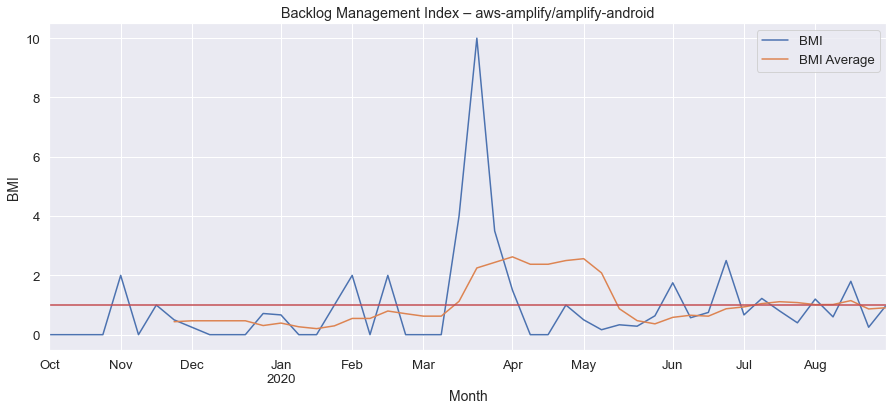

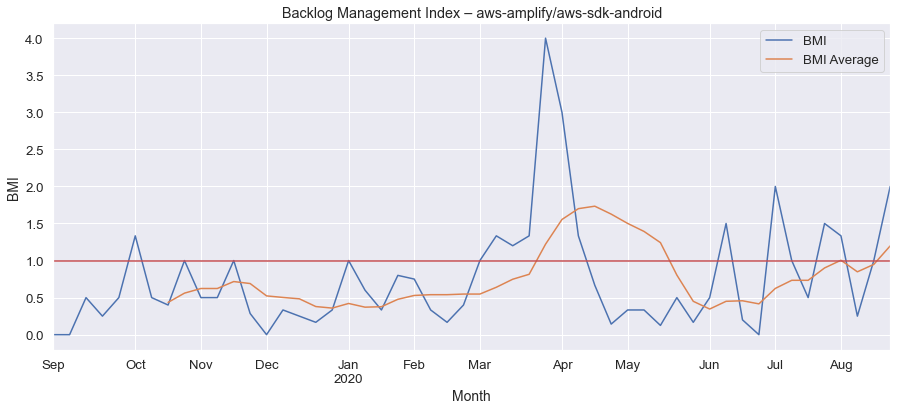

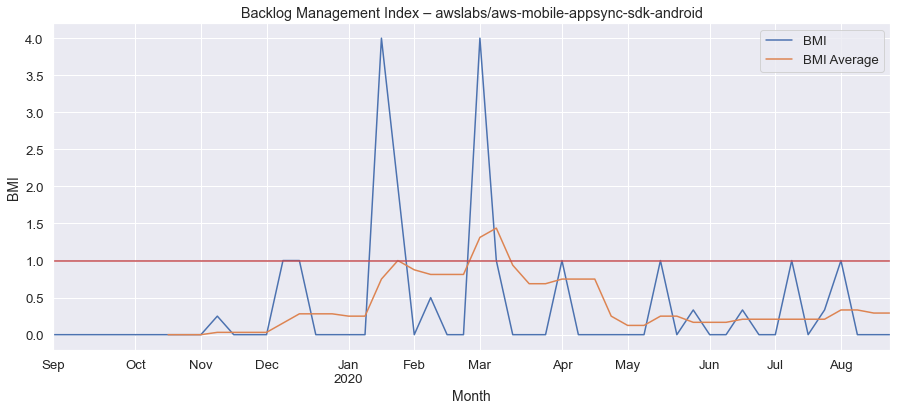

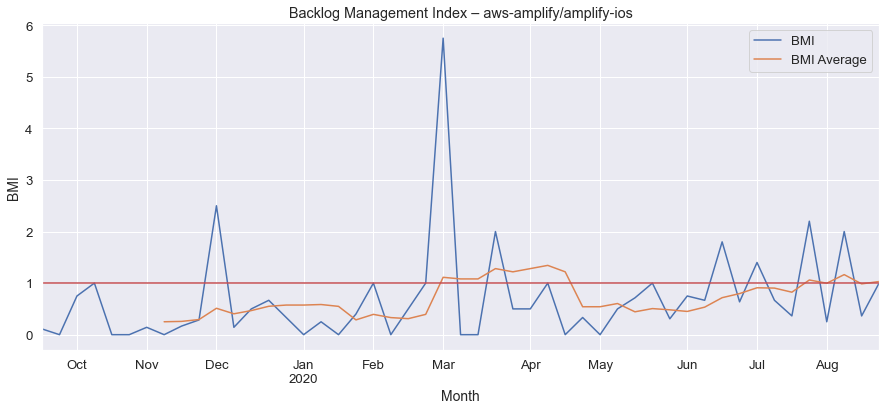

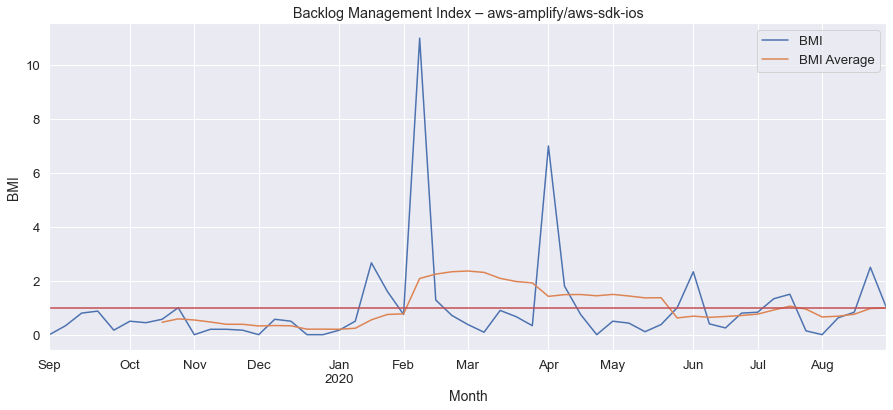

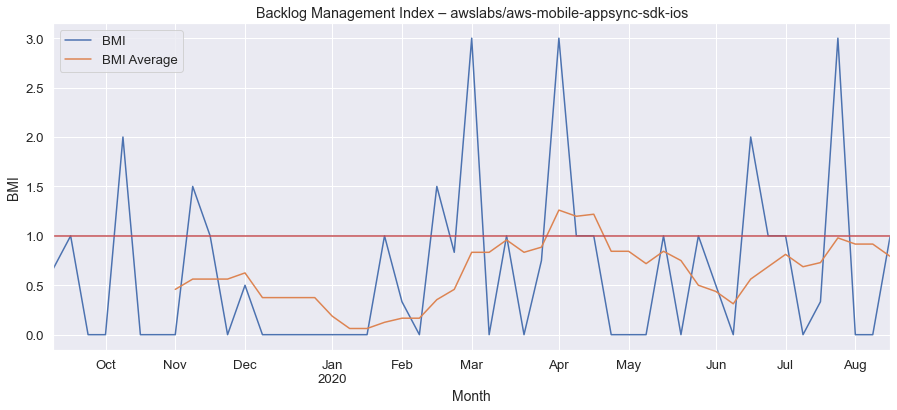

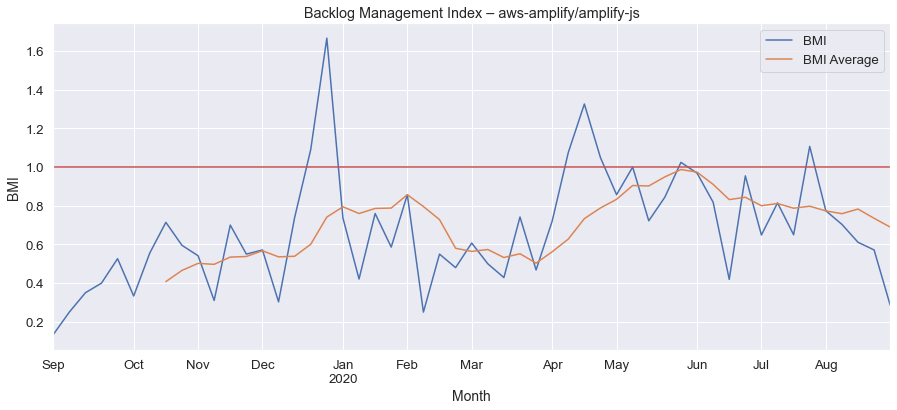

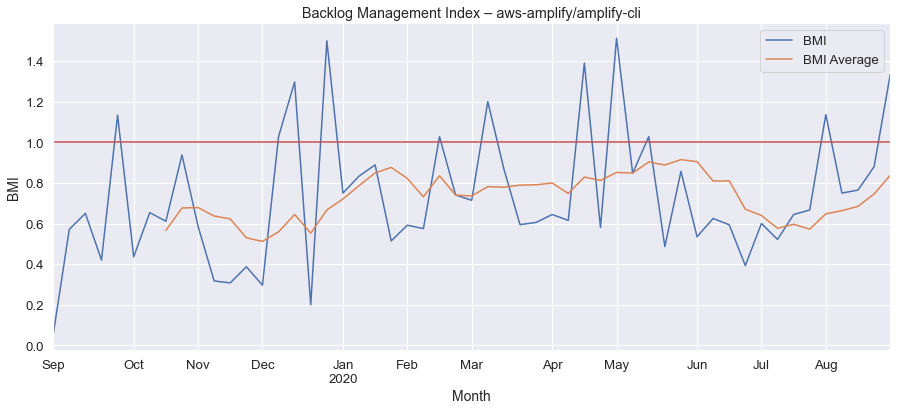

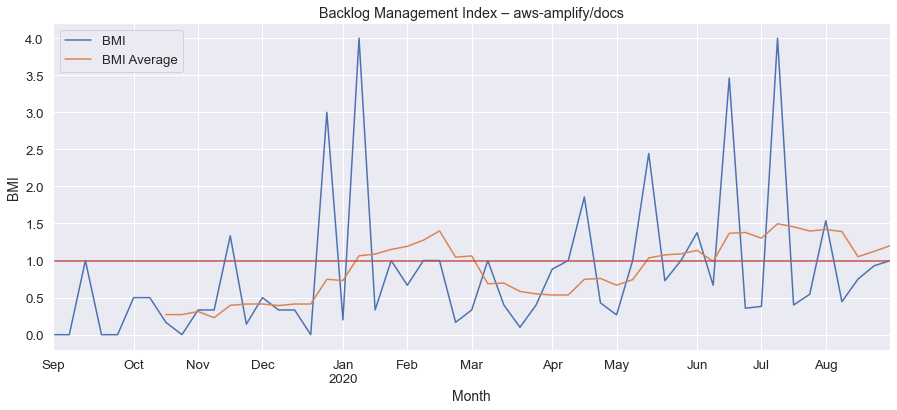

In [8]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Management Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()

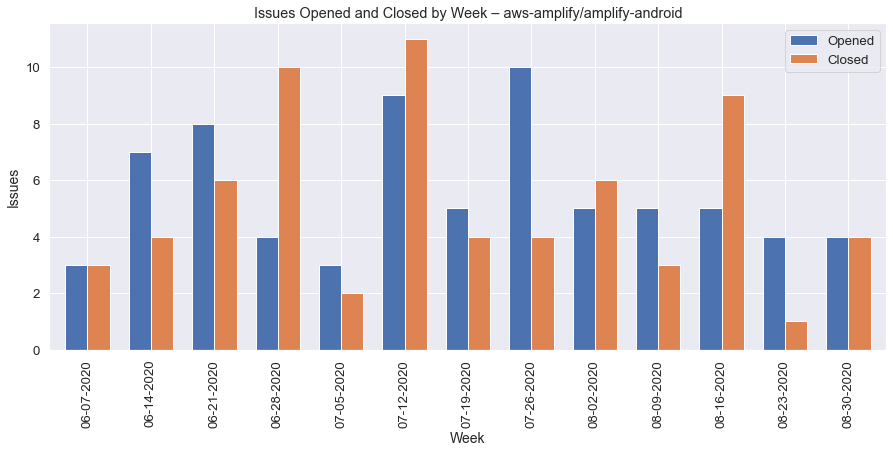

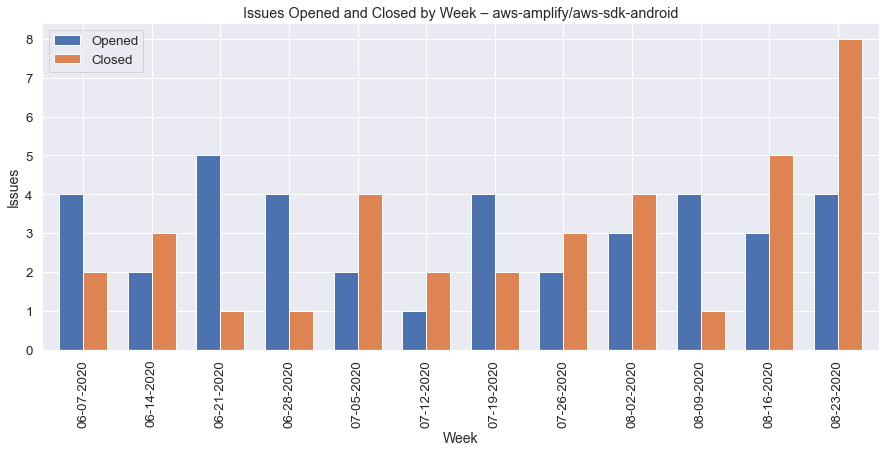

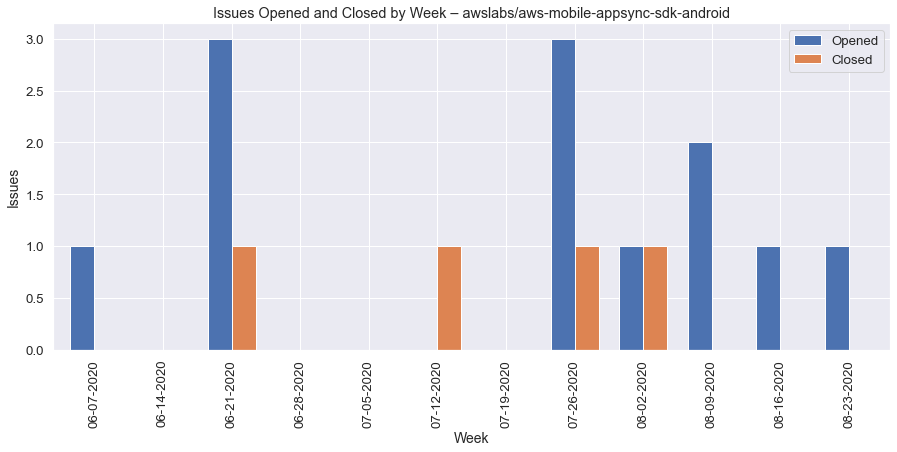

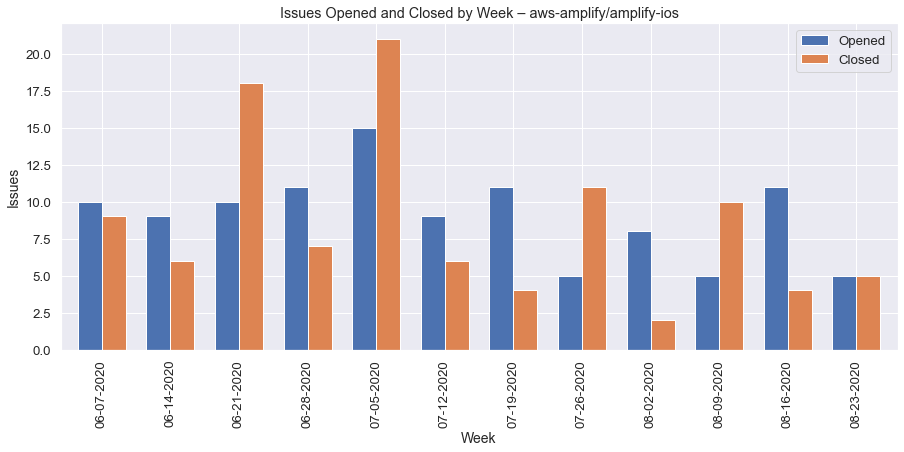

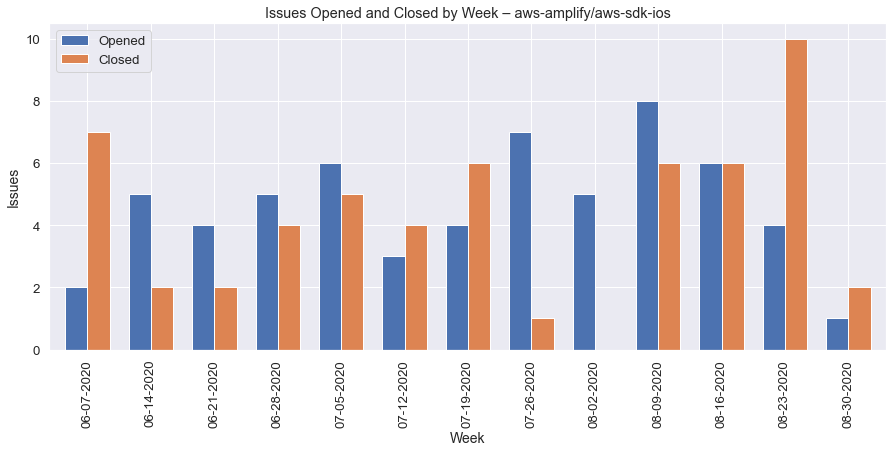

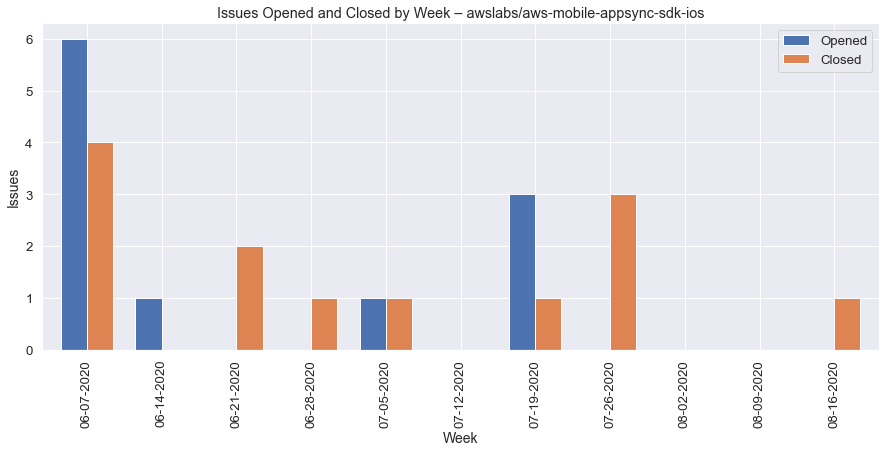

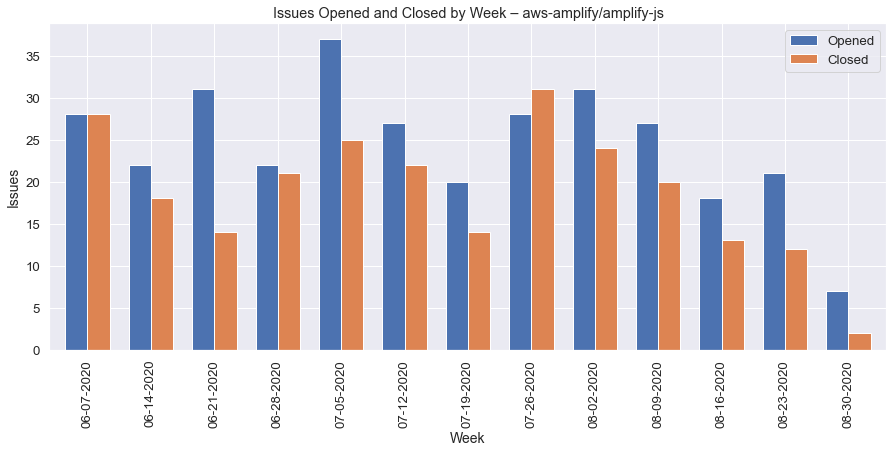

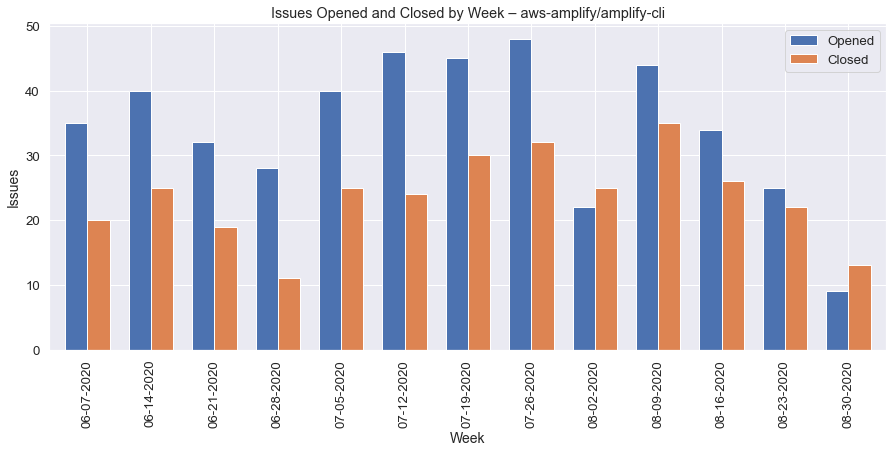

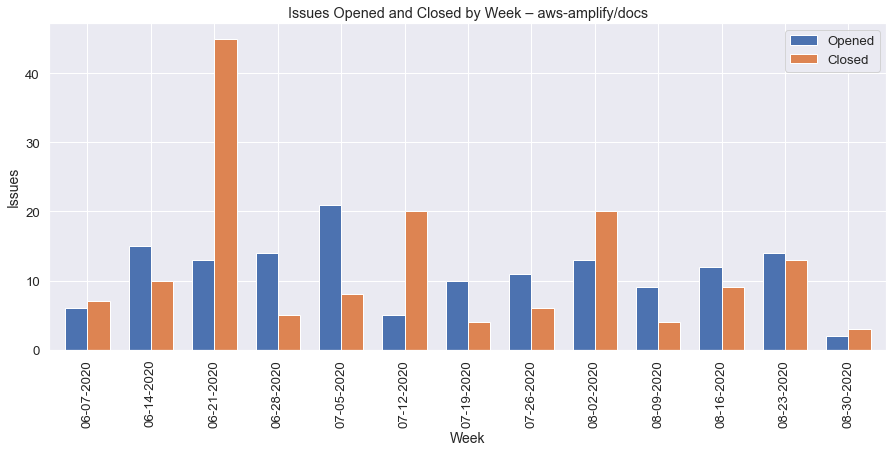

In [9]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

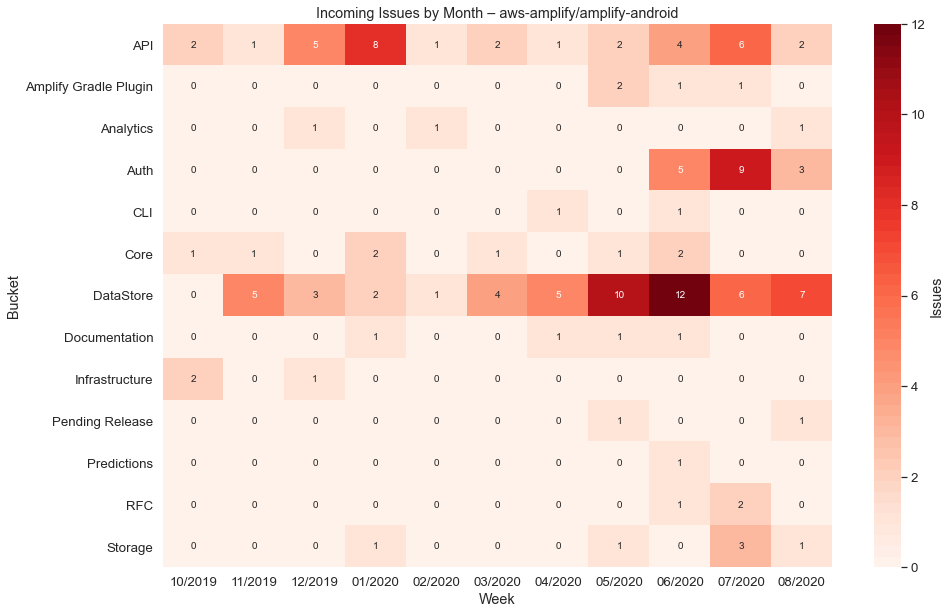

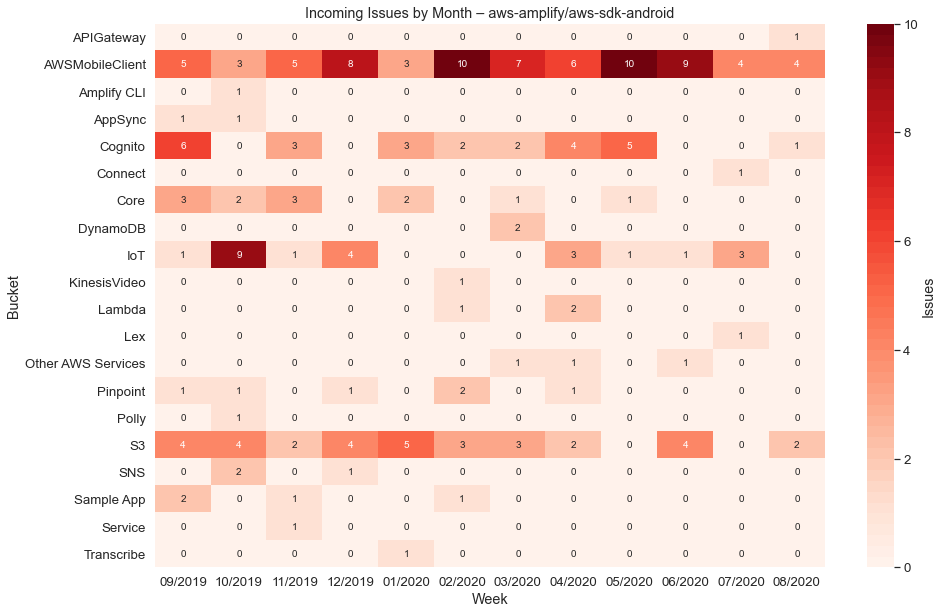

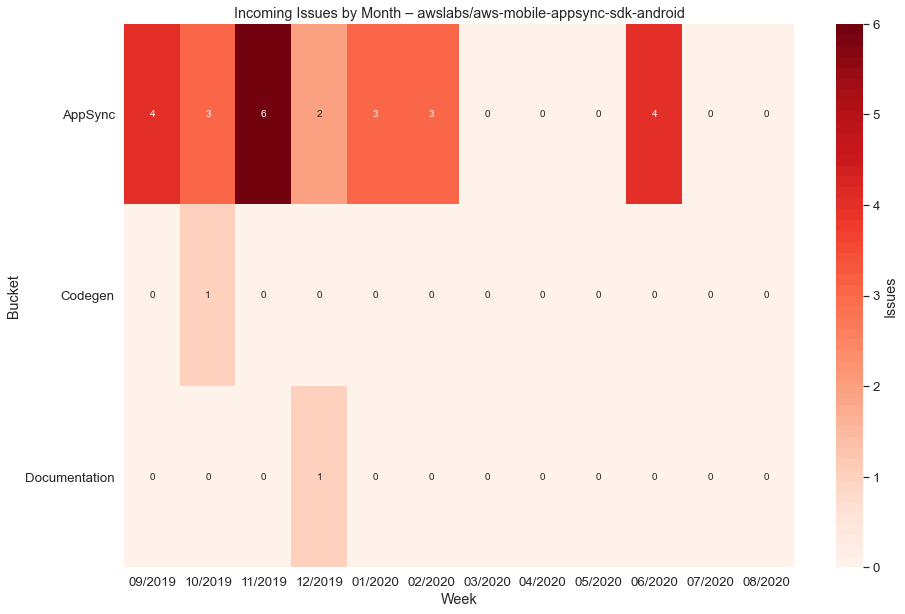

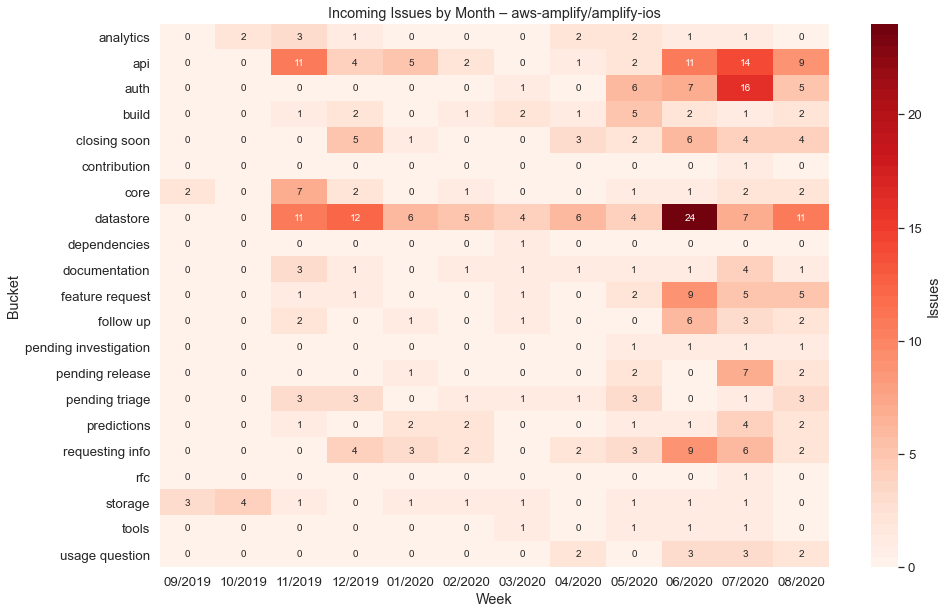

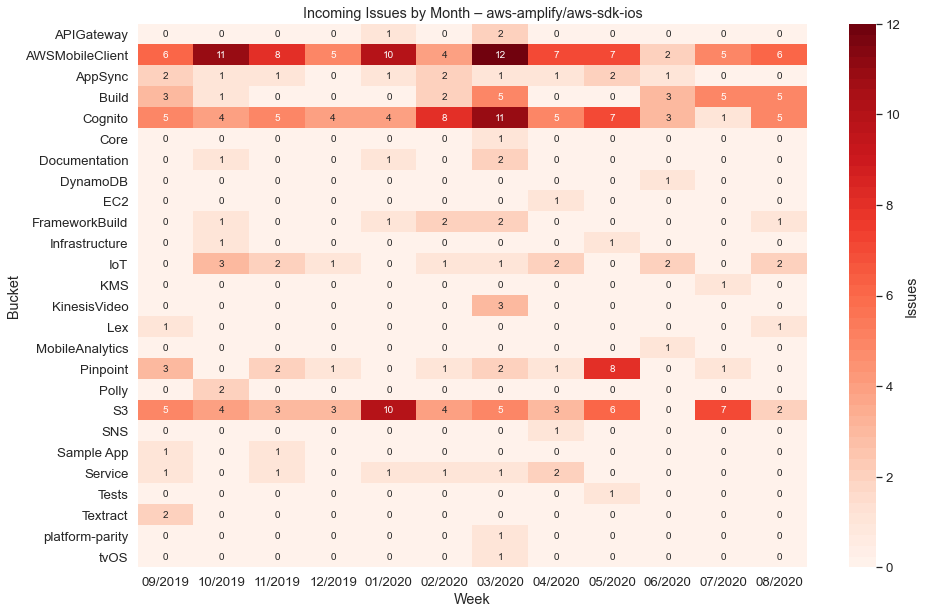

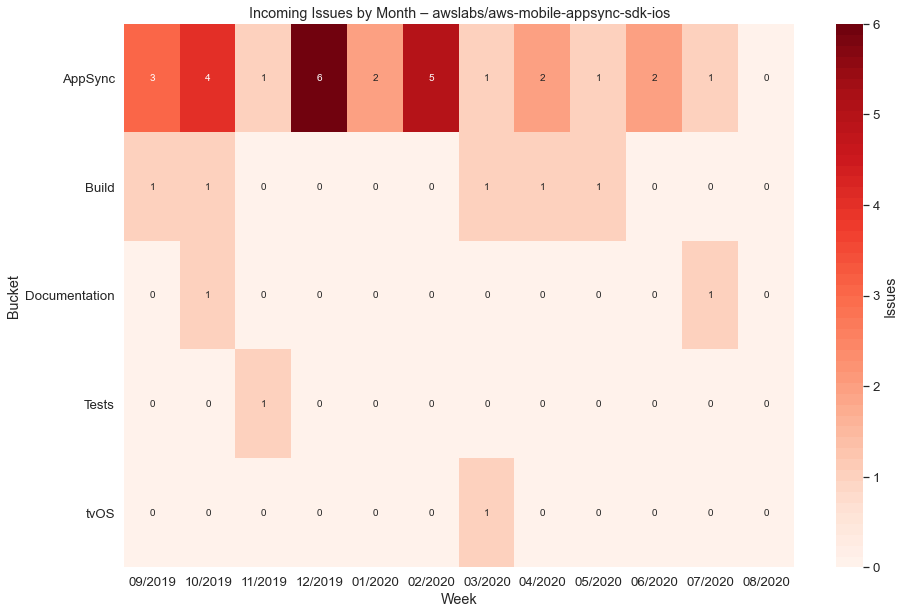

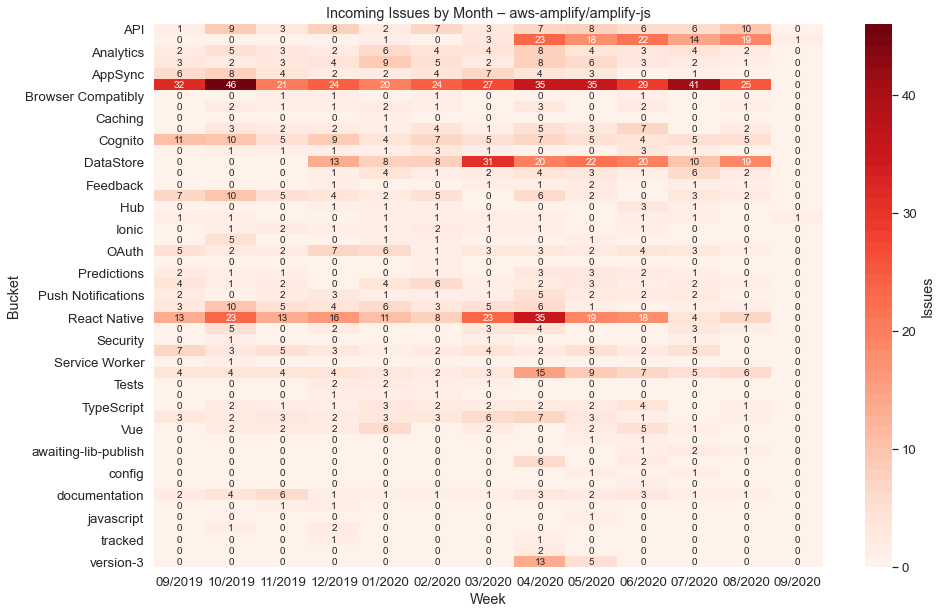

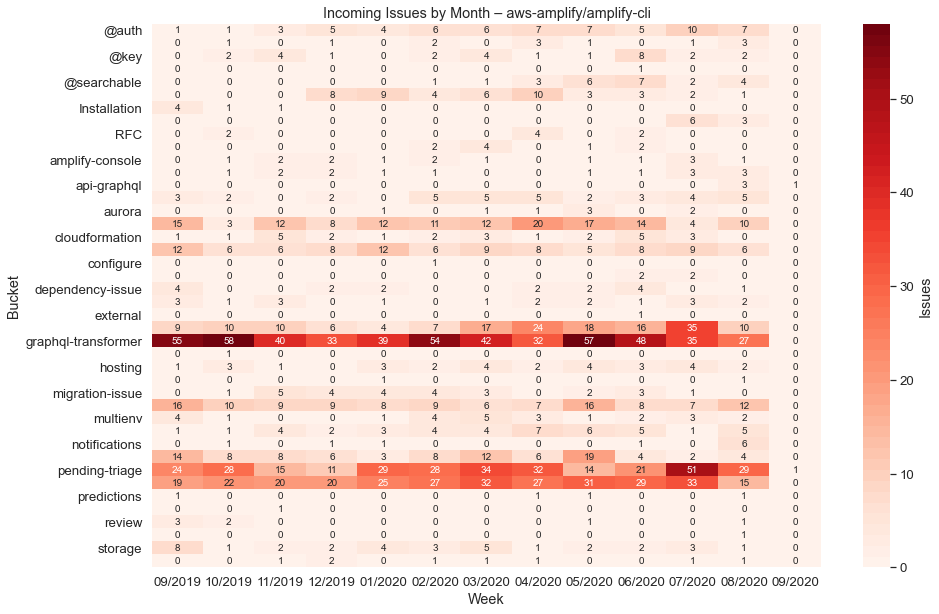

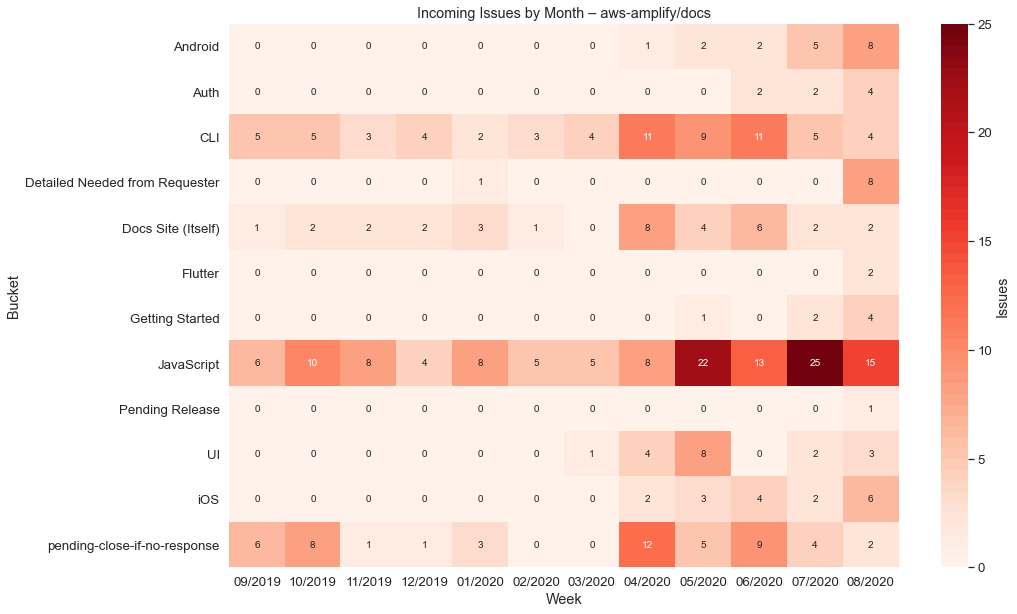

In [10]:
# Incoming Issues by Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():    
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').count().transpose()
    
    if (len(df)):
        plt.subplots(figsize=(15, 10))

        dates = df.columns.strftime('%m/%Y').unique()
        ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='.0f', annot=True,
                         cbar_kws={'label': 'Issues'})

        ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Month – {repo_name}')
        plt.yticks(rotation=0)
        plt.show()

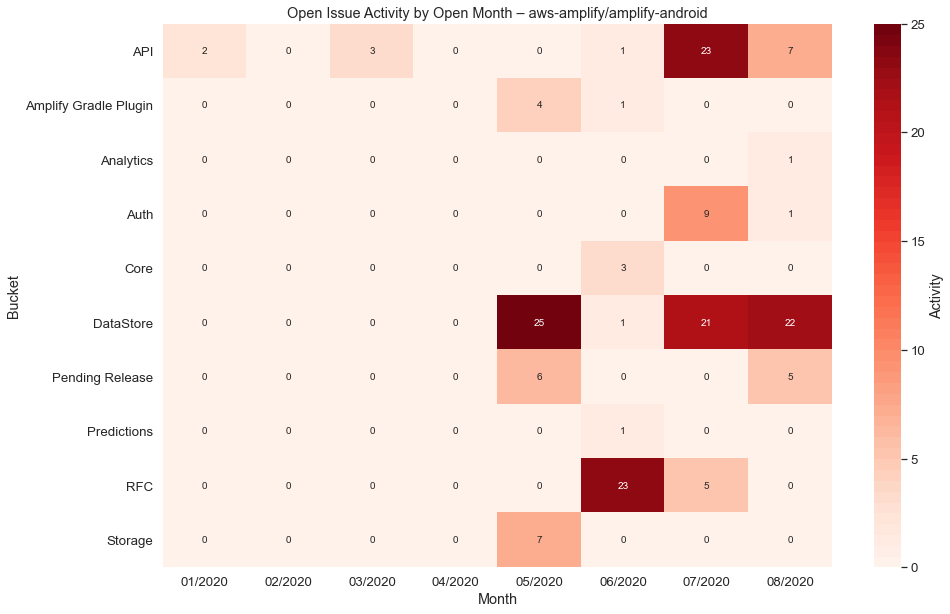

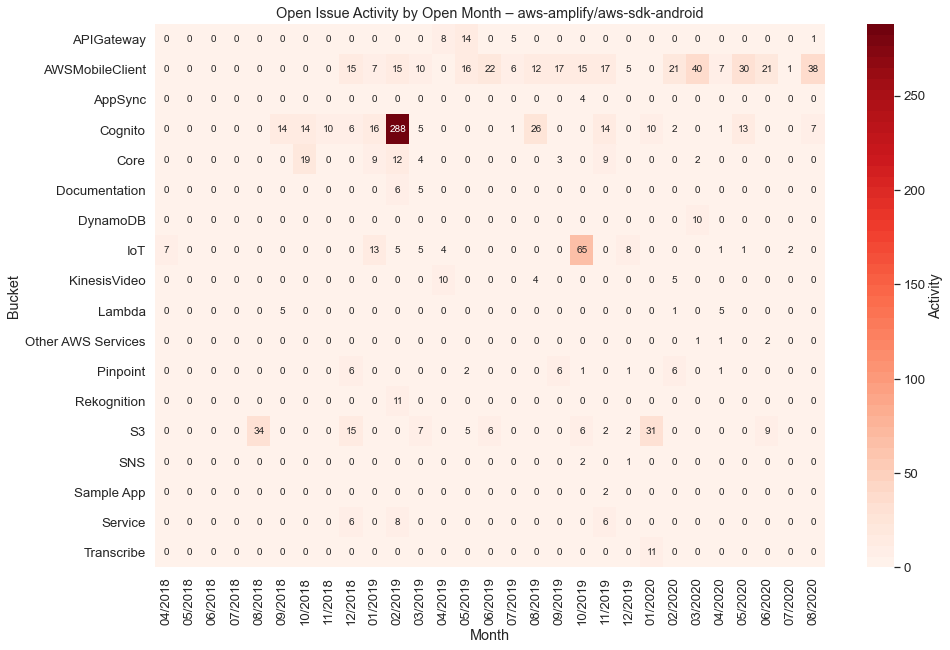

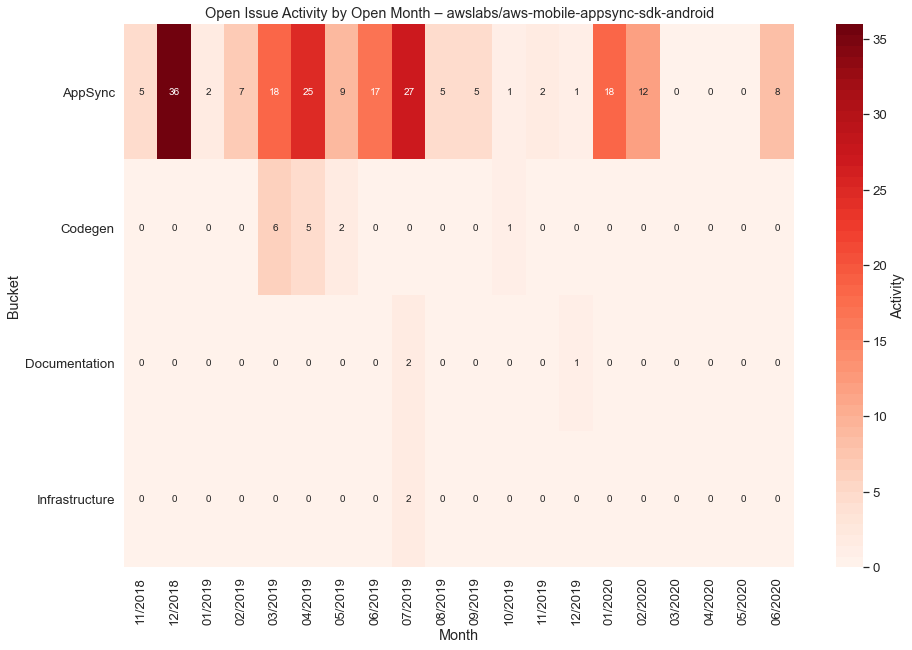

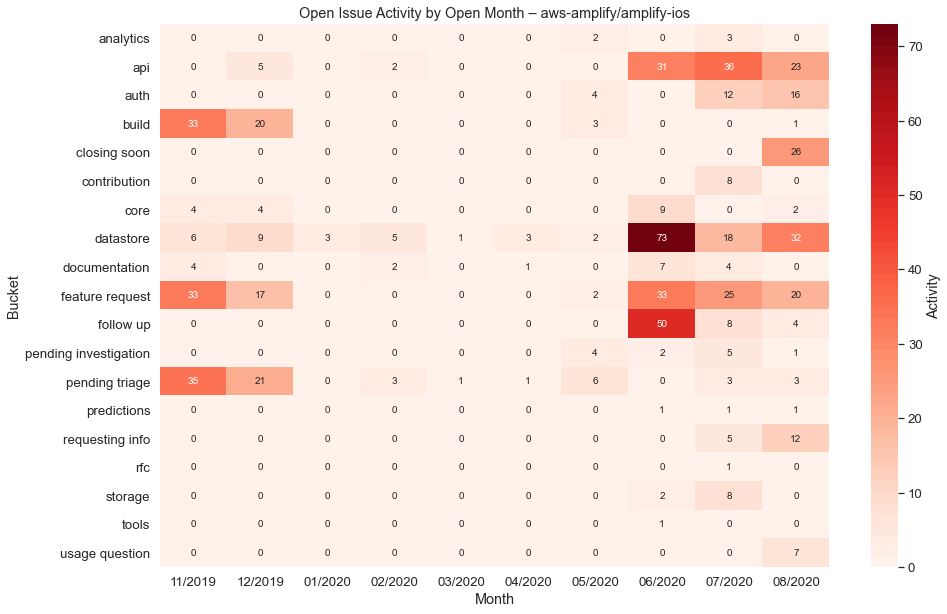

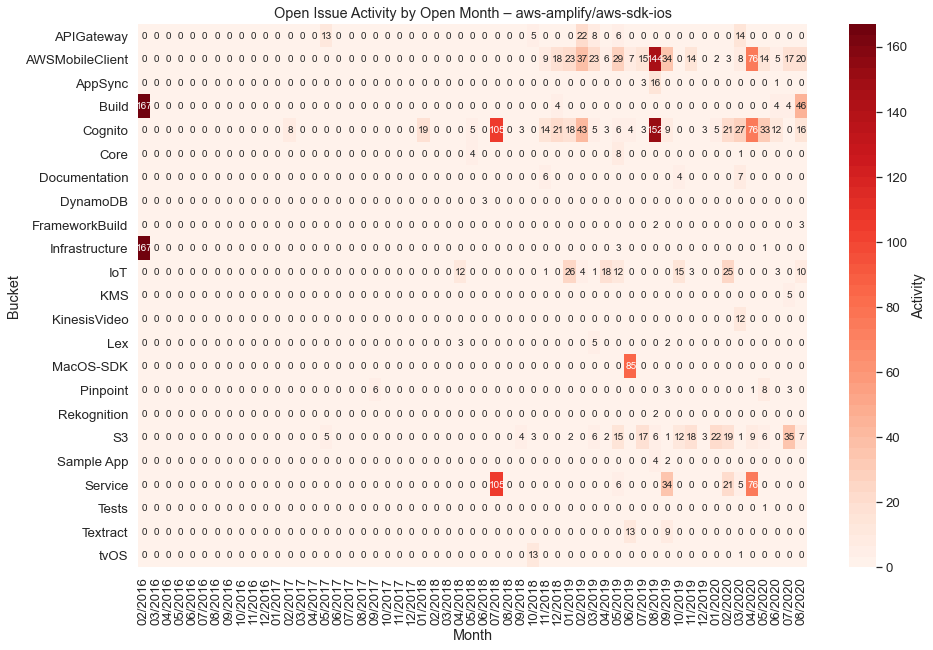

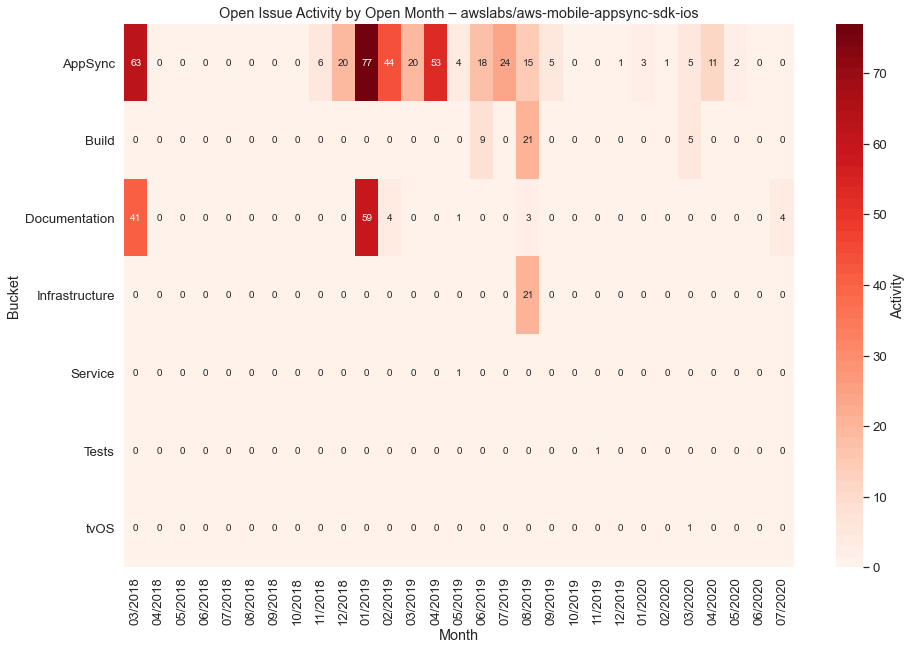

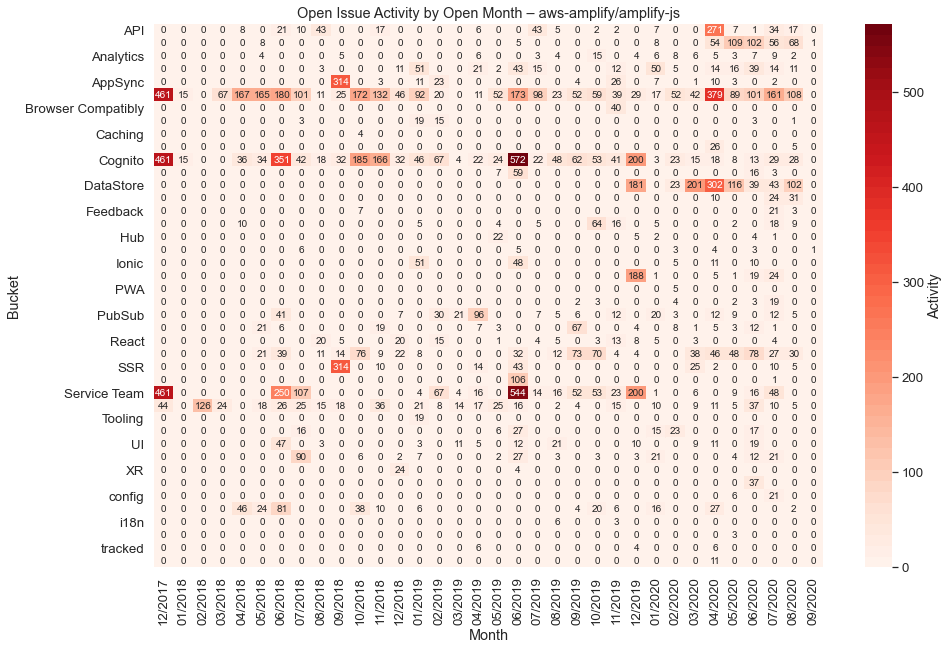

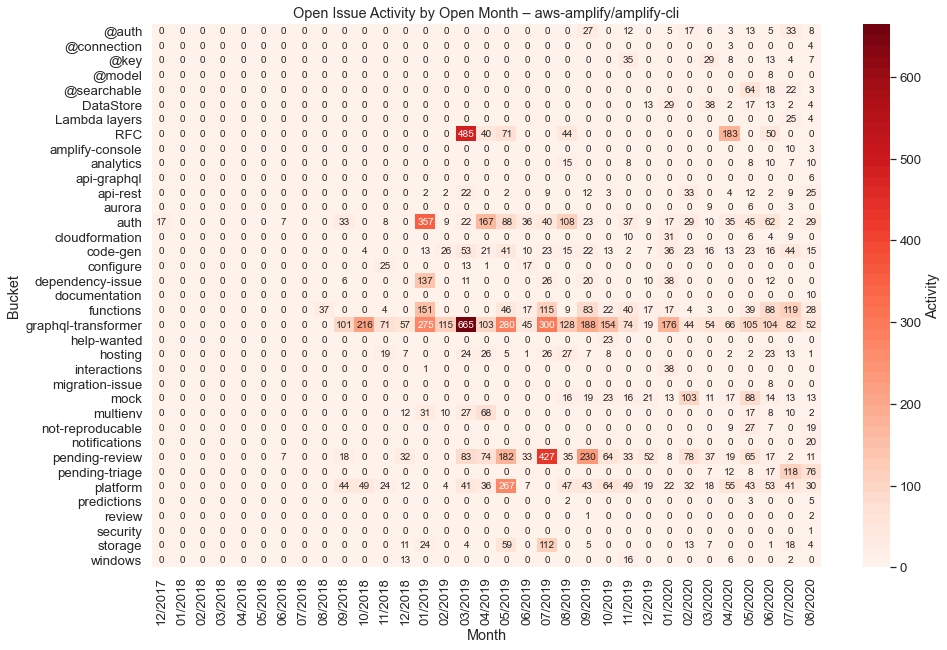

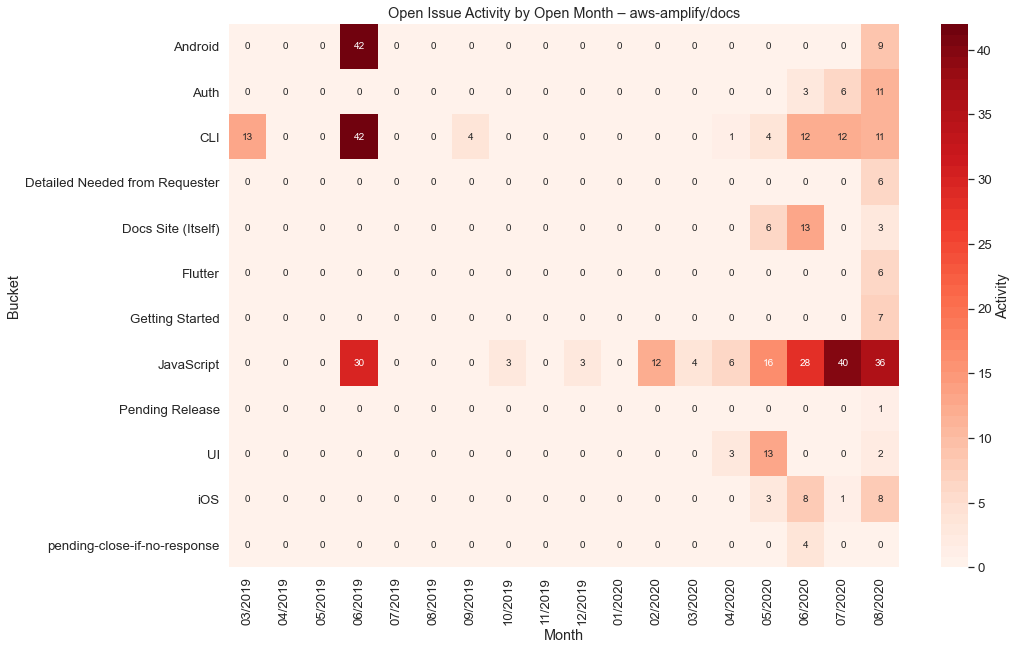

In [11]:
# Open Issues Activity by Open Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 10))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette('Reds', 50), annot=True, fmt='.0f',
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Issue Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

In [14]:
##### Closed Issue Report

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Closed Issues</h1>'))

seven_days_ago = datetime.now() - pd.Timedelta('7 days')
seven_days_ago = seven_days_ago.astimezone(pytz.timezone('UTC'))

for repo_name, df in repos.items():
    df = df[(df.closed_at > seven_days_ago)]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'closed_at', 'labels', 'score']])

,id,title,created_at,closed_at,labels,score
151,748,Social sign in crashes the browser without any error messages,2020-08-22 15:23:53+00:00,2020-08-25 17:23:14+00:00,"[Auth, Bug, Closing Soon]",12
123,657,Amplify.addPlugin produces a crash when I start my app for API level lower than 21,2020-07-21 00:00:48+00:00,2020-08-31 18:15:09+00:00,[Bug],9
112,629,Access Denied | Store data in S3 bucket,2020-07-07 17:02:19+00:00,2020-08-31 18:11:46+00:00,"[Bug, Storage]",2
126,668,Special characters inside URL path causes REST API to return signature mismatch error,2020-07-24 16:47:29+00:00,2020-08-31 18:17:31+00:00,"[API, Bug]",2
157,773,"2020-08-31 15:46:52.152 10584-10584/com.example.myamplifyapp E/MyAmplifyApp: Upload failed AmplifyException {message=Issue uploading file., cause=java.lang.IllegalArgumentException: Invalid file: null,",2020-08-31 10:45:57+00:00,2020-08-31 11:54:42+00:00,[],1


,id,title,created_at,closed_at,labels,score
935,1721,Cognito sign in with unconfirmed user throws different exception now,2020-05-10 18:59:39+00:00,2020-08-25 19:30:23+00:00,"[AWSMobileClient, Bug]",11
954,1813,[Hosted UI] Can't use getUserAttributes() without the aws.cognito.signin.user.admin scope,2020-06-03 10:48:50+00:00,2020-08-25 15:01:27+00:00,"[AWSMobileClient, Usage Question]",7
970,1976,How to add federated users to Cognito user pool,2020-06-28 21:52:37+00:00,2020-08-25 14:28:17+00:00,"[AWSMobileClient, Usage Question]",6
917,1576,Resume a paused upload transfer can not receive onProgressChanged callback,2020-04-16 11:32:54+00:00,2020-08-25 15:14:17+00:00,"[Bug, S3]",5
903,1524,HostedUIOptions for Facebook and Google opens white blank screen for few seconds,2020-03-21 04:25:45+00:00,2020-08-25 15:16:22+00:00,"[AWSMobileClient, Feature Request]",4
969,1974,Unable to resume confirm forgot password if not started by SDK,2020-06-30 15:00:15+00:00,2020-08-25 14:53:10+00:00,"[AWSMobileClient, Usage Question]",2


,id,title,created_at,closed_at,labels,score


,id,title,created_at,closed_at,labels,score
222,640,credentialsFetchLock.leave() - Federated sign in crash,2020-07-12 23:05:41+00:00,2020-08-30 20:15:25+00:00,"[auth, bug, pending release]",15
242,675,"i am having json and converting to data.and passing put request getting 400 error. let request = RESTRequest(path: urlStr, body: data) _ = Amplify.API.put(request:request) { result in switch result { case .success(let data):}",2020-07-26 13:40:05+00:00,2020-08-27 16:55:13+00:00,"[api, closing soon, requesting info]",8
203,613,"""Sign In With Apple"" - AWSCognitoAuthErrorDomain Code=-3000",2020-07-02 13:16:36+00:00,2020-08-27 16:56:49+00:00,"[auth, closing soon, requesting info]",5
272,740,Declaration 'resultPublisher' cannot override more than one superclass declaration,2020-08-25 09:00:25+00:00,2020-08-25 14:57:06+00:00,"[build, duplicate]",3
274,744,Declaration 'resultPublisher' cannot override more than one superclass declaration,2020-08-27 15:23:42+00:00,2020-08-27 23:12:59+00:00,[duplicate],2


,id,title,created_at,closed_at,labels,score
1581,2943,AWSLex fails to build in Xcode 12 beta 4,2020-08-14 13:13:55+00:00,2020-08-28 16:25:14+00:00,"[Build, Lex, Pending]",7
1524,2652,Attributes from targetingClient should return values from remote (even after reinstall).,2020-05-26 16:40:13+00:00,2020-08-29 07:55:12+00:00,"[Pinpoint, Requesting Feedback, bug]",6
1557,2854,Occasional unexpected 401 responses for valid tokens,2020-07-13 15:35:22+00:00,2020-08-29 07:55:14+00:00,"[AWSMobileClient, Requesting Feedback, closing-soon-if-no-response]",6
1567,2904,"User Pools, Hosted UI - SignOut",2020-08-01 15:12:35+00:00,2020-08-25 15:53:28+00:00,"[AWSMobileClient, question]",5
1589,2963,OTP Authentication using Cognito custom authentication,2020-08-21 12:36:52+00:00,2020-08-31 11:42:35+00:00,[Cognito],5
1139,1490,Crash in AWSSRWebSocket.m line 773,2019-04-22 01:14:45+00:00,2020-08-31 19:33:13+00:00,"[IoT, bug]",4
1586,2960,Getting unidentified random user from Cognito pool,2020-08-19 12:57:44+00:00,2020-08-25 18:26:53+00:00,"[Cognito, question]",4
1560,2869,"Can't upload file with custom endpoints, application hangs",2020-07-22 19:58:27+00:00,2020-08-29 07:55:13+00:00,"[Requesting Feedback, S3, closing-soon-if-no-response]",3
1572,2915,trying to add pods to an objective c project,2020-08-06 13:59:30+00:00,2020-08-27 01:28:37+00:00,"[Build, Requesting Feedback, closing-soon-if-no-response]",3
1592,2975,When can we expect to use ASWebAuthenticationSession vs SFAuthenticationSession,2020-08-27 17:41:53+00:00,2020-08-27 20:01:34+00:00,[],3


,id,title,created_at,closed_at,labels,score


,id,title,created_at,closed_at,labels,score
3493,5729,"Storage.put, Storage.get with protected images give 403 error out of the box on localhost",2020-02-24 00:22:01+00:00,2020-08-29 19:20:52+00:00,"[Storage, pending-close-response-required]",135
3292,5290,DataStore subscriptions with combined authorization rules not working (bug),2020-03-31 19:50:59+00:00,2020-08-31 13:57:45+00:00,"[DataStore, React Native, feature-request]",19
3712,6134,"Auth.signIn throws error: AuthClass - Failed to get the signed in user – ""No current user""",2020-06-22 09:00:14+00:00,2020-08-27 01:37:21+00:00,"[Auth, Can't reproduce, pending-close-response-required]",17
3814,6329,Auth.updateUserAttributes not working,2020-07-15 06:14:35+00:00,2020-08-28 04:45:06+00:00,"[Auth, to-be-reproduced]",13
3958,6637,React Native - Apple Sign In,2020-08-24 21:35:33+00:00,2020-08-25 22:12:22+00:00,"[OAuth, React Native, to-be-reproduced]",10
3961,6644,[Feedback]More Control over the styling.,2020-08-25 14:27:07+00:00,2020-08-26 22:45:09+00:00,"[Amplify UI Components, React, feature-request]",9
3967,6664,Can't upload file to S3 using aws-amplify possibly due to slash in bucket name,2020-08-27 05:10:21+00:00,2020-08-28 21:51:18+00:00,"[Storage, pending-close-response-required, question]",9
3127,5024,aws-amplify-angular cannot be used with strict Content Security Policy,2020-03-03 00:58:06+00:00,2020-08-31 21:16:35+00:00,[Interactions],8
3923,6572,Failed to fetch unauthenticated user on chrome,2020-08-13 19:19:08+00:00,2020-08-27 07:21:40+00:00,"[Auth, to-be-reproduced]",8
3948,6616,Unable to retrieve guest/unauthenticated credentials after identity becomes disabled,2020-08-21 13:21:57+00:00,2020-08-28 21:54:59+00:00,[Auth],5


,id,title,created_at,closed_at,labels,score
225,365,Tag Support,2018-10-28 01:30:56+00:00,2020-08-31 23:10:17+00:00,"[cloudformation, feature-request]",83
2917,4607,RFC: Amplify CLI - Tag support,2020-06-18 21:00:40+00:00,2020-08-31 23:09:49+00:00,"[RFC, feature-request]",42
3284,5171,UnhandledPromiseRejectionWarning: NoSuchBucket: The specified bucket does not exist,2020-08-25 16:34:47+00:00,2020-08-25 18:58:51+00:00,[question],29
3267,5144,Amplify-CLI not working (amplify add auth),2020-08-20 20:01:01+00:00,2020-08-31 14:16:47+00:00,"[auth, not-reproducable, pending-close-response-required]",13
3200,5049,Where are the EC2 instances of ElasticSearch?,2020-08-11 00:23:15+00:00,2020-08-25 23:13:06+00:00,"[@searchable, pending-close-response-required, question]",10
3294,5190,Cognito and Pinpoint in different regions,2020-08-28 07:15:44+00:00,2020-08-31 17:26:56+00:00,"[auth, notifications, question]",8
3292,5186,Interactions category creates resources in the wrong region,2020-08-27 03:43:46+00:00,2020-08-31 21:59:18+00:00,"[enhancement, good-first-issue, interactions]",8
3288,5177,Lambda function in Go with GraphQL,2020-08-26 12:42:01+00:00,2020-08-27 00:38:29+00:00,"[functions, graphql-transformer, pending-close-response-required]",8
3237,5101,sorted @connection with @key with multiple fields,2020-08-16 01:05:02+00:00,2020-08-28 17:26:01+00:00,"[graphql-transformer, pending-response, question]",8
3227,5085,"""amplify mock function <>"" pending for a few hours",2020-08-14 03:57:35+00:00,2020-08-31 19:08:53+00:00,"[enhancement, mock]",8


,id,title,created_at,closed_at,labels,score
187,766,"Documentation about the ""aws-exports"" file",2019-02-07 14:45:17+00:00,2020-08-31 21:01:53+00:00,"[CLI, Feature Request]",138
484,1939,"[amplify mock function] explain `event.json`, `function-parameters.json`, `parameters.json`, `amplify.state` and other autogenerated files",2020-06-09 20:17:39+00:00,2020-08-31 17:48:16+00:00,[CLI],13
522,2039,Correct syntax for event.json when mocking a PreSignUp triggered lambda function,2020-04-18 09:19:57+00:00,2020-08-28 21:59:08+00:00,[CLI],9
625,2319,Complete new password does not exist :(,2020-08-28 05:33:43+00:00,2020-08-29 05:04:44+00:00,"[Android, Auth, Feature Request]",6
568,2152,[Feedback]Vue Tutorial broken at amplify publish step.,2020-07-27 07:14:48+00:00,2020-08-27 15:37:57+00:00,"[Getting Started, JavaScript]",5
614,2289,[Feedback]<amplify-s3-album /> gives an ERROR,2020-08-24 10:38:26+00:00,2020-08-26 05:25:08+00:00,"[JavaScript, UI]",4
617,2297,[Feedback] Missing Documentation,2020-08-25 09:32:59+00:00,2020-08-27 15:21:53+00:00,[JavaScript],4
536,2069,[Feedback] missing how to sign out from social web UI,2020-07-07 07:10:42+00:00,2020-08-27 15:30:45+00:00,[Android],3
553,2101,[Feedback] custom cf does not require `dependsOn`,2020-07-12 20:23:37+00:00,2020-08-28 22:07:34+00:00,[CLI],3
627,2322,[Feedback]FEEDBACK_TITLE_HERE,2020-08-28 15:31:05+00:00,2020-08-28 15:51:23+00:00,[Duplicate],3


In [13]:
from datetime import datetime
from IPython.display import display, HTML

total = (datetime.now() - start).seconds
minutes, seconds = divmod(total, 60)

if minutes:
    display(HTML(f'<em>Report generation took {minutes}min, {seconds}sec'))
else:
    display(HTML(f'<em>Report generation took {seconds}sec'))